#  INIT

In [1]:
import sys
sys.path.append('../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../infras/')
sys.path.append('../infras/dashboards/')
sys.path.append('../experiments/')
sys.path.append('../experiments/pipeline/')
sys.path.append('../preprocess/intra_variance/')
sys.path.append('../models/cell_proportions/')
sys.path.append('../measures/cell_proportions_measures/')
sys.path.append('../preprocess/cell_specifics/')
sys.path.append('../preprocess/data_sets/')

from pp_clean_high_intra_var import PpCleanHighIntraVar
from aggregate_intra_variance import AggregateIntraVariance
from cellMix_coordinator import CellMixCoordinator

import exploration_plots
import dashs

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from itertools import chain
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

from scipy.stats import entropy
from functools import reduce
import matplotlib.patches as patches


import os

In [3]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

# from deconv_py.infras.cellMix.cellMix_coordinator import CellMixCoordinator

In [4]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20190801_filtered_imputed_data.csv'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'),as_csv = True)
data_factory = DataFactory(data_loader)
ms = data_loader.get_mass_spec_data()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
from deconv_py.preprocess.cell_specifics.pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from deconv_py.preprocess.cell_specifics.pp_entropy_based import PpEntropyBased
from deconv_py.models.cell_proportions.basic import BasicDeconv

## read data - intensities

### mixture & cell specific data

**LFQ:** rel. quantification – for same protein across different samples

**iBAQ:** orthogonal comparison – for different proteins in the same sample

In [6]:
relvent_data_iBAQ = data_factory._build_relvent_data( DataFactory.IBD_A_RELVENT_DATA,"iBAQ")
profile_data_iBAQ,profile_data_relvent_data_iBAQ = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data_iBAQ,relvent_columns=["Majority protein IDs","Gene names"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data= ms.columns.tolist() ,relvent_columns=["Majority protein IDs","Gene.names"],auto_filter_by=False,log2_transformation=True)

## build A ,X and B 

In [7]:
index_func = lambda x:x
_profile_data_iBAQ,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data_iBAQ,mixtures,index_func=index_func)
A_iBAQ = _profile_data_iBAQ[profile_data_relvent_data_iBAQ]
B = _mixtures[mixtures_relvent_data]
# X = cell_proportions_df

In [8]:
A_all_vs,_, = data_factory.load_IBD_all_vs("iBAQ",with_granulocytes=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [9]:
# B=B.rename({f:f.split('Intensity ')[1] for f in B.columns},axis=1)

# X = X.rename({f:f.split('Intensity ')[1] for f in X.index},axis=0)
# X = X.rename({f:'mixture'+str(f) for f in X.columns},axis=1)

A_iBAQ = A_iBAQ.rename({f:f.split('iBAQ ')[1] for f in A_iBAQ.columns},axis=1)

# Comparisons

## DICE

In [10]:
mass_cell_to_gene_cell_map = {'NOT_BCellmemory_01': None,
                                  'NOT_BCellnaive_01':'B_CELL_NAIVE',
                                  'NOT_BCellplasma_01':None,
                                  'NOT_CD4TCellmTregs_01':'T cell, CD4, memory TREG',
                                  'NOT_CD4TCellnaive_01':'T cell, CD4, naive' ,
                                  'NOT_CD4TCellnTregs_01':'T cell, CD4, naive TREG',
                                  'NOT_CD4TCellTcm_01':None ,
                                  'NOT_CD4TCellTem_01': None,
                                  'NOT_CD4TCellTemra_01':None,
                                  'NOT_CD4TCellTh1_01':'T cell, CD4, TH1' ,
                                  'NOT_CD4TCellTh17_01':'T cell, CD4, TH17',
                                  'NOT_CD4TCellTh2_01':'T cell, CD4, TH2' ,
                                  'NOT_CD8TCellnaive_01':'T cell, CD8, naive',
                                  'NOT_CD8TCellTcm_01': None,
                                  'NOT_CD8TCellTem_01':None ,
                                  'NOT_CD8TCellTemra_01':None,
                                  'NOT_DendriticCD1c_01':None,
                                  'NOT_DendriticCD304_01':None,
                                  'NOT_Erythrocytes_01': None,
                                  'NOT_Monocytesclassical_01':'MONOCYTES' ,
                                  'NOT_Monocytesintermediate_01':None,
                                  'NOT_Monocytesnonclassical_01':'MONOCYTES_NON_CLASSICAL',
                                  'NOT_NKCellsCD56bright_01': None,
                                  'NOT_NKCellsCD56dim_01':'NK cell, CD56dim CD16+' ,
                                  'NOT_Thrombocytes_01': None,
                                  'NOT_Granulocyteseosinophils_01':None,
                                  'NOT_GranulocytesBasophil_01':None
                               }
mass_cell_to_gene_cell_map = {('iBAQ '+k):v for k,v in mass_cell_to_gene_cell_map.items()}
gene_expression = pd.read_csv("../data/gene_expression_per_cell.csv").rename(columns={v:k for k,v in mass_cell_to_gene_cell_map.items()})
gene_expression = gene_expression.set_index("Gene name")

relvent_with_genes =  profile_data_relvent_data_iBAQ + ["Gene names"]
_A_with_gene_iBAQ = profile_data_iBAQ[relvent_with_genes].set_index("Gene names")

In [11]:
cell_ref_freq = pd.read_csv('../data/cell_references_frequency.csv')
cell_to_freq_map = cell_ref_freq[["mass_name","range_srt"]].set_index("mass_name").to_dict()["range_srt"]

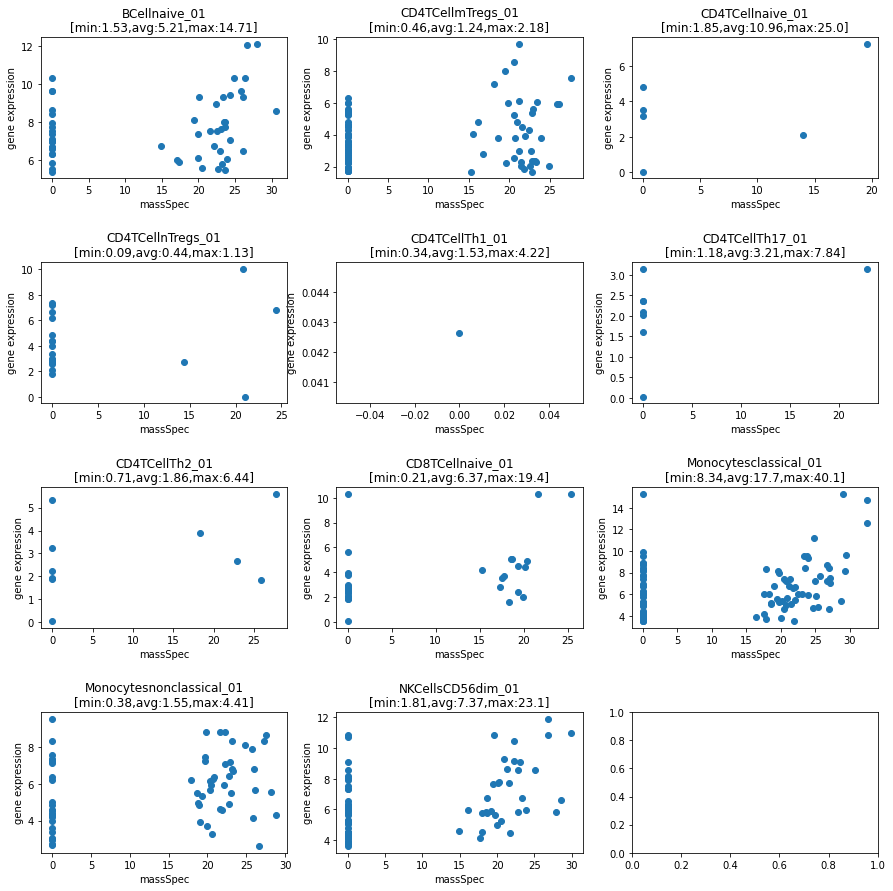

In [12]:
results = {}
for _cell in _A_with_gene_iBAQ.columns :
    if _cell in gene_expression.columns:
        merged_df = _A_with_gene_iBAQ[_cell].to_frame().merge(gene_expression[_cell].to_frame(),left_index = True,right_index = True)
        merged_df = merged_df.dropna(how="any")
        cell_name = _cell.split('iBAQ NOT_')[1]
        results[cell_name] = merged_df

fig,axs = plt.subplots(int(np.ceil(len(results)/3)),3,figsize=(15,15))

for (cell_name,df),ax in zip(results.items(),axs.reshape(-1)) : 
    ax.scatter(np.log2(1+ df[df.columns[0]]),np.log2(1 + df[df.columns[1]]))
    ax.set_title(f"{cell_name}\n{cell_to_freq_map[cell_name]}")
    ax.set_xlabel("massSpec")
    ax.set_ylabel("gene expression")
plt.subplots_adjust(hspace = 0.6)

## human proteins atlas 

**Transcript expression levels summarized per gene in 18 blood cell types and total PBMC** 


**protein-coding transcripts per million ("pTPM"):** 
fraction of transcripts per million of total transcripts from protein-coding genes - The pTPM values can be used to investigate the abundance of a particular gene, gene family, or gene class relative to all other transcripts in a particular cell, tissue, or organ. 

**normalized expression ("NX"):**
The objective of using the NX value is to facilitate the
analysis of differences in expression of genes
between cells, tissues, and organs and to allow for a specificity classification based on the
genome-wide expression of all genes across the
human blood cells, tissues, and organs.

***The data is based on The Human Protein Atlas version 19.1 and Ensembl version 92.38.


In [13]:
rna_blood_cell_df = pd.read_csv("../data/gene_expression/human atlas/rna_blood_cell.tsv",sep="\t")
rna_blood_cell_df =rna_blood_cell_df.loc[~rna_blood_cell_df[["Gene name","Blood cell"]].duplicated()]
ptmp_rna_cell_df = rna_blood_cell_df.pivot(index = "Gene name",columns="Blood cell",values="pTPM")
nx_rna_cell_df = rna_blood_cell_df.pivot(index = "Gene name",columns="Blood cell",values="NX")


In [44]:
nx_rna_cell_df

Blood cell,MAIT T-cell,NK-cell,T-reg,basophil,classical monocyte,eosinophil,gdT-cell,intermediate monocyte,memory B-cell,memory CD4 T-cell,memory CD8 T-cell,myeloid DC,naive B-cell,naive CD4 T-cell,naive CD8 T-cell,neutrophil,non-classical monocyte,plasmacytoid DC,total PBMC
Gene name,,,,,,,,,,,,,,,,,,,
A1BG,0.5,0.0,1.0,0.0,0.1,0.0,0.0,0.0,0.1,0.4,0.5,0.5,0.6,0.0,0.3,0.0,0.0,1.6,0.7
A1CF,0.1,0.2,0.0,1.6,0.1,0.2,0.1,0.0,0.0,0.0,0.1,0.0,0.2,0.1,0.1,0.3,0.0,0.0,0.0
A2M,2.6,0.0,0.0,0.0,0.4,0.0,4.4,0.2,0.2,0.5,1.2,0.3,0.0,0.1,0.7,0.0,0.0,1.4,0.3
A2ML1,0.7,1.5,0.4,1.8,0.7,0.4,0.9,1.0,0.9,0.4,0.4,0.3,1.0,0.5,0.6,1.7,2.0,1.2,0.2
A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,2.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.4,0.8,0.5,2.4,0.8,1.6,1.1,0.4,0.3,0.8,0.8,1.4,1.0,1.1,1.0,2.5,7.6,2.2,0.4
ZYG11A,0.3,0.9,0.4,1.8,0.6,0.8,0.5,0.3,0.7,0.5,0.5,0.1,1.0,0.6,0.7,3.1,0.3,0.8,0.2
ZYG11B,2.3,2.1,3.0,1.0,2.4,2.7,2.1,1.3,2.2,2.6,1.6,2.2,2.1,3.8,2.7,5.7,2.0,1.7,1.0


### build different profiles to different agg and var filtering

In [15]:
pp_intra_var = PpCleanHighIntraVar(how="std")
agg_first = AggregateIntraVariance(how="first")
agg_mean = AggregateIntraVariance(how="mean")
agg_med = AggregateIntraVariance(how="median")
agg_max = AggregateIntraVariance(how="max")

pp_intrv_genes = pp_intra_var.transform([A_all_vs,A_all_vs])[0].index.droplevel(0)

A_iBaq_mean_agg = agg_mean.transform([A_all_vs,None])[0]
A_iBaq_mean_agg.index = A_iBaq_mean_agg.index.droplevel(0)

A_iBaq_first_agg = agg_first.transform([A_all_vs,None])[0]
A_iBaq_first_agg.index = A_iBaq_first_agg.index.droplevel(0)

A_iBaq_med_agg = agg_med.transform([A_all_vs,None])[0]
A_iBaq_med_agg.index = A_iBaq_med_agg.index.droplevel(0)

A_iBaq_max_agg = agg_max.transform([A_all_vs,None])[0]
A_iBaq_max_agg.index = A_iBaq_max_agg.index.droplevel(0)


In [16]:
print(sum(A_iBaq_first_agg['iBAQ NOT_BCellmemory']==0))
print(sum(A_iBaq_max_agg['iBAQ NOT_BCellmemory']==0))

715
392


### build corresponding profiles

In [17]:
mass_cell_to_gene_cell_map = {    'NOT_BCellmemory': 'memory B-cell',
                                  'NOT_BCellnaive' : 'naive B-cell',
                                  'NOT_BCellplasma' : None,
                                  'NOT_CD4TCellmTregs' : 'T-reg',
                                  'NOT_CD4TCellnaive':'naive CD4 T-cell',
                                  'NOT_CD4TCellnTregs':'T-reg',
                                  'NOT_CD4TCellTcm' : 'memory CD4 T-cell' ,
                                  'NOT_CD4TCellTem' : None,
                                  'NOT_CD4TCellTemra' :None,
                                  'NOT_CD4TCellTh1':None,
                                  'NOT_CD4TCellTh17':None,
                                  'NOT_CD4TCellTh2':None,
                                  'NOT_CD8TCellnaive':'naive CD8 T-cell',
                                  'NOT_CD8TCellTcm' : 'memory CD8 T-cell',
                                  'NOT_CD8TCellTem' : None ,
                                  'NOT_CD8TCellTemra' : None,
                                  'NOT_DendriticCD1c' : None,
                                  'NOT_DendriticCD304' : None,
                                  'NOT_Erythrocytes' : None,
                                  'NOT_Monocytesclassical': 'classical monocyte' ,
                                  'NOT_Monocytesintermediate' : 'intermediate monocyte',
                                  'NOT_Monocytesnonclassical': 'non-classical monocyte',
                                  'NOT_NKCellsCD56bright' : 'NK-cell',
                                  'NOT_NKCellsCD56dim': 'NK-cell',
                                  'NOT_Thrombocytes' : None,
                                  'NOT_Granulocyteseosinophils' : "eosinophil",
                                  'NOT_GranulocytesBasophil' : "basophil"}
mass_cell_to_gene_cell_map = {('iBAQ '+k):v for k,v in mass_cell_to_gene_cell_map.items()}

def return_corosponding_profiles(home_profile,out_profile,mass_cell_to_gene_cell_map) : 
    def get_home_cor_gene(out_gene,mut_genes_multiple,mut_genes):
        if out_gene in mut_genes : 
            return out_gene
        if out_gene in mut_genes_multiple.keys():
            return mut_genes_multiple[out_gene]

    out_genes = nx_rna_cell_df.index.dropna().drop_duplicates()
    home_genes = home_profile.index.dropna().drop_duplicates()

    home_genes_multiple = [genes for genes in home_genes if ";" in genes] 
    mut_genes_multiple = {}
    for out_gene in out_genes : 
        for home_gene in home_genes_multiple:
            if out_gene in home_gene:
                mut_genes_multiple[out_gene] = home_gene

    mut_genes = out_genes.intersection(home_genes)
    
    filt_out_profile = out_profile.copy(deep=True).loc[mut_genes.union(pd.Index(mut_genes_multiple.keys()))]
    filt_out_profile["home_cor_gene"] = filt_out_profile.index.map(lambda out_gene:get_home_cor_gene(out_gene,mut_genes_multiple,mut_genes))
    #mean the duplicates : 
    filt_out_profile = filt_out_profile.groupby("home_cor_gene").mean()
    filt_home_profile = home_profile.loc[filt_out_profile.index]
    
    only_mut_cells_home_profile = filt_home_profile.rename(columns = mass_cell_to_gene_cell_map)[[col for col in mass_cell_to_gene_cell_map.values() if col is not 'None']]
    only_mut_cells_home_profile = only_mut_cells_home_profile.groupby(lambda x:x,axis=1).sum()
    only_mut_cells_out_df = filt_out_profile[only_mut_cells_home_profile.columns]
    return  only_mut_cells_home_profile,only_mut_cells_out_df

genes_filtered_by_intra_var = pp_intrv_genes.dropna()

filt_iBAQ_profile_mean_agg,filt_ptmp_rna_cell_df = return_corosponding_profiles(A_iBaq_mean_agg,ptmp_rna_cell_df,mass_cell_to_gene_cell_map)
filt_iBAQ_profile_first_agg,_ = return_corosponding_profiles(A_iBaq_first_agg,ptmp_rna_cell_df,mass_cell_to_gene_cell_map)
filt_iBAQ_profile_med_agg,_ = return_corosponding_profiles(A_iBaq_med_agg,ptmp_rna_cell_df,mass_cell_to_gene_cell_map)
filt_iBAQ_profile_max_agg,_ = return_corosponding_profiles(A_iBaq_max_agg,ptmp_rna_cell_df,mass_cell_to_gene_cell_map)

### all atlas

In [18]:
def plot_results_by_agg_option(mass_profiles_dict,gene_profile,genes_filtered_by_intra_var):
    '''
    mass_profile_dict = agg_type_str:profile_aggrigeted
    '''
    results = {}
    for _cell in gene_profile.columns : 
        for agg_method,mass_profile in mass_profiles_dict.items():
            merged_df = mass_profile[_cell].to_frame().merge(gene_profile[_cell].to_frame(),left_index = True,right_index = True)
            merged_df = merged_df.dropna(how="any")
            merged_df_low_intravar = merged_df.loc[genes_filtered_by_intra_var]
            merged_df_low_intravar = merged_df_low_intravar.dropna(how="any")
            
            cell_name =_cell
            
            results[f"{cell_name},agg by {agg_method}"] = merged_df
            results[f"{cell_name},agg by {agg_method}-low intra var"]=merged_df_low_intravar


    for (cell_name,df),ax_index in zip(results.items(),range(len(results))) : 
        if (np.mod(ax_index,8) == 0 ) :
            fig,axs = plt.subplots(4,2,figsize=(25,25))
            axs = axs.reshape(-1)
            
        x = np.log2(1+ df[df.columns[0]])
        y = np.log2(1 + df[df.columns[1]])

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        axs[np.mod(ax_index,8)].scatter(x, y, c=z,s=100, edgecolor='')
        axs[np.mod(ax_index,8)].set_title(f"{cell_name}")
        axs[np.mod(ax_index,8)].set_xlabel("massSpec")
        axs[np.mod(ax_index,8)].set_ylabel("gene expression")
#         plt.savefig(f'figures_pdfs/comparing profile to gene profile with agg and filter ({cell_name.split(",")[0]})')  

    plt.subplots_adjust(hspace = 1)
    
mass_profiles_dict={"mean" :filt_iBAQ_profile_mean_agg ,
                   "first" :filt_iBAQ_profile_first_agg ,
                   "med" :filt_iBAQ_profile_med_agg ,
                   "max" :filt_iBAQ_profile_max_agg }

# %matplotlib inline
# plot_results_by_agg_option(mass_profiles_dict,filt_ptmp_rna_cell_df,genes_filtered_by_intra_var)

### unexpected zeros

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


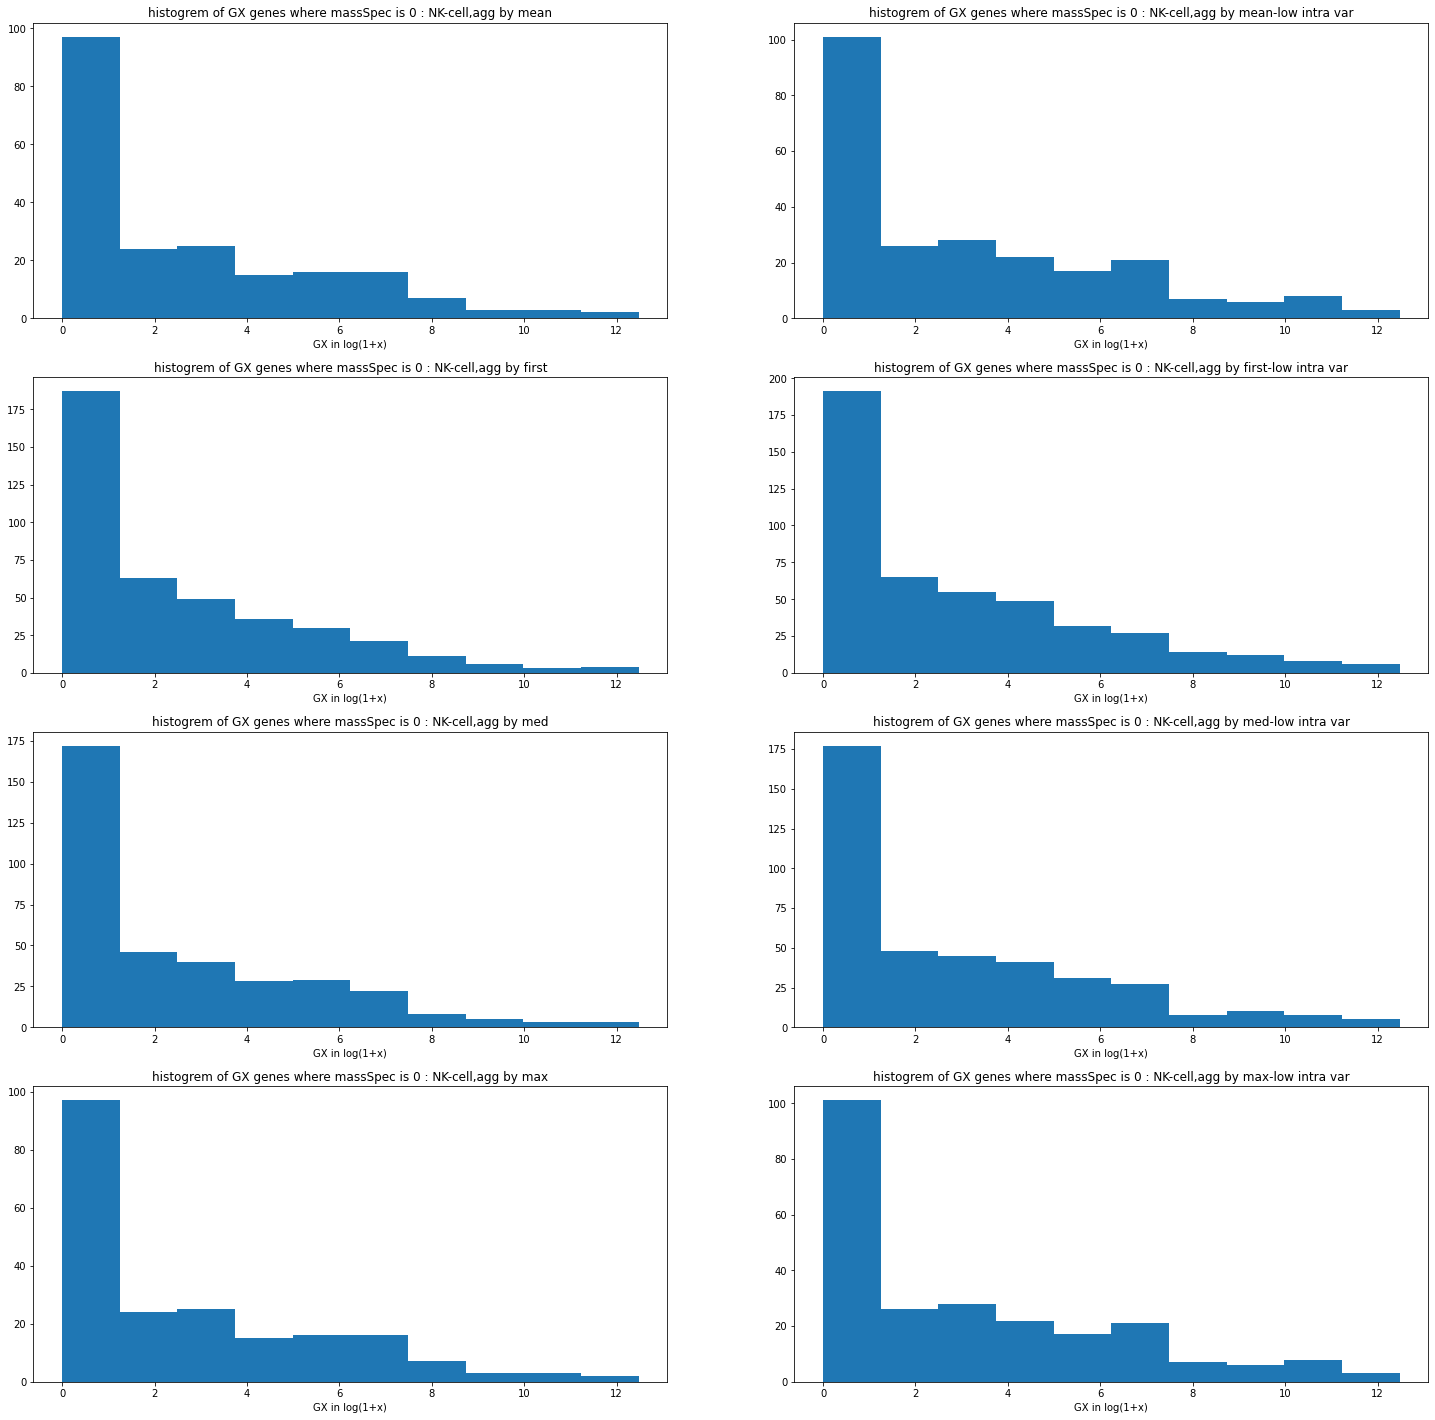

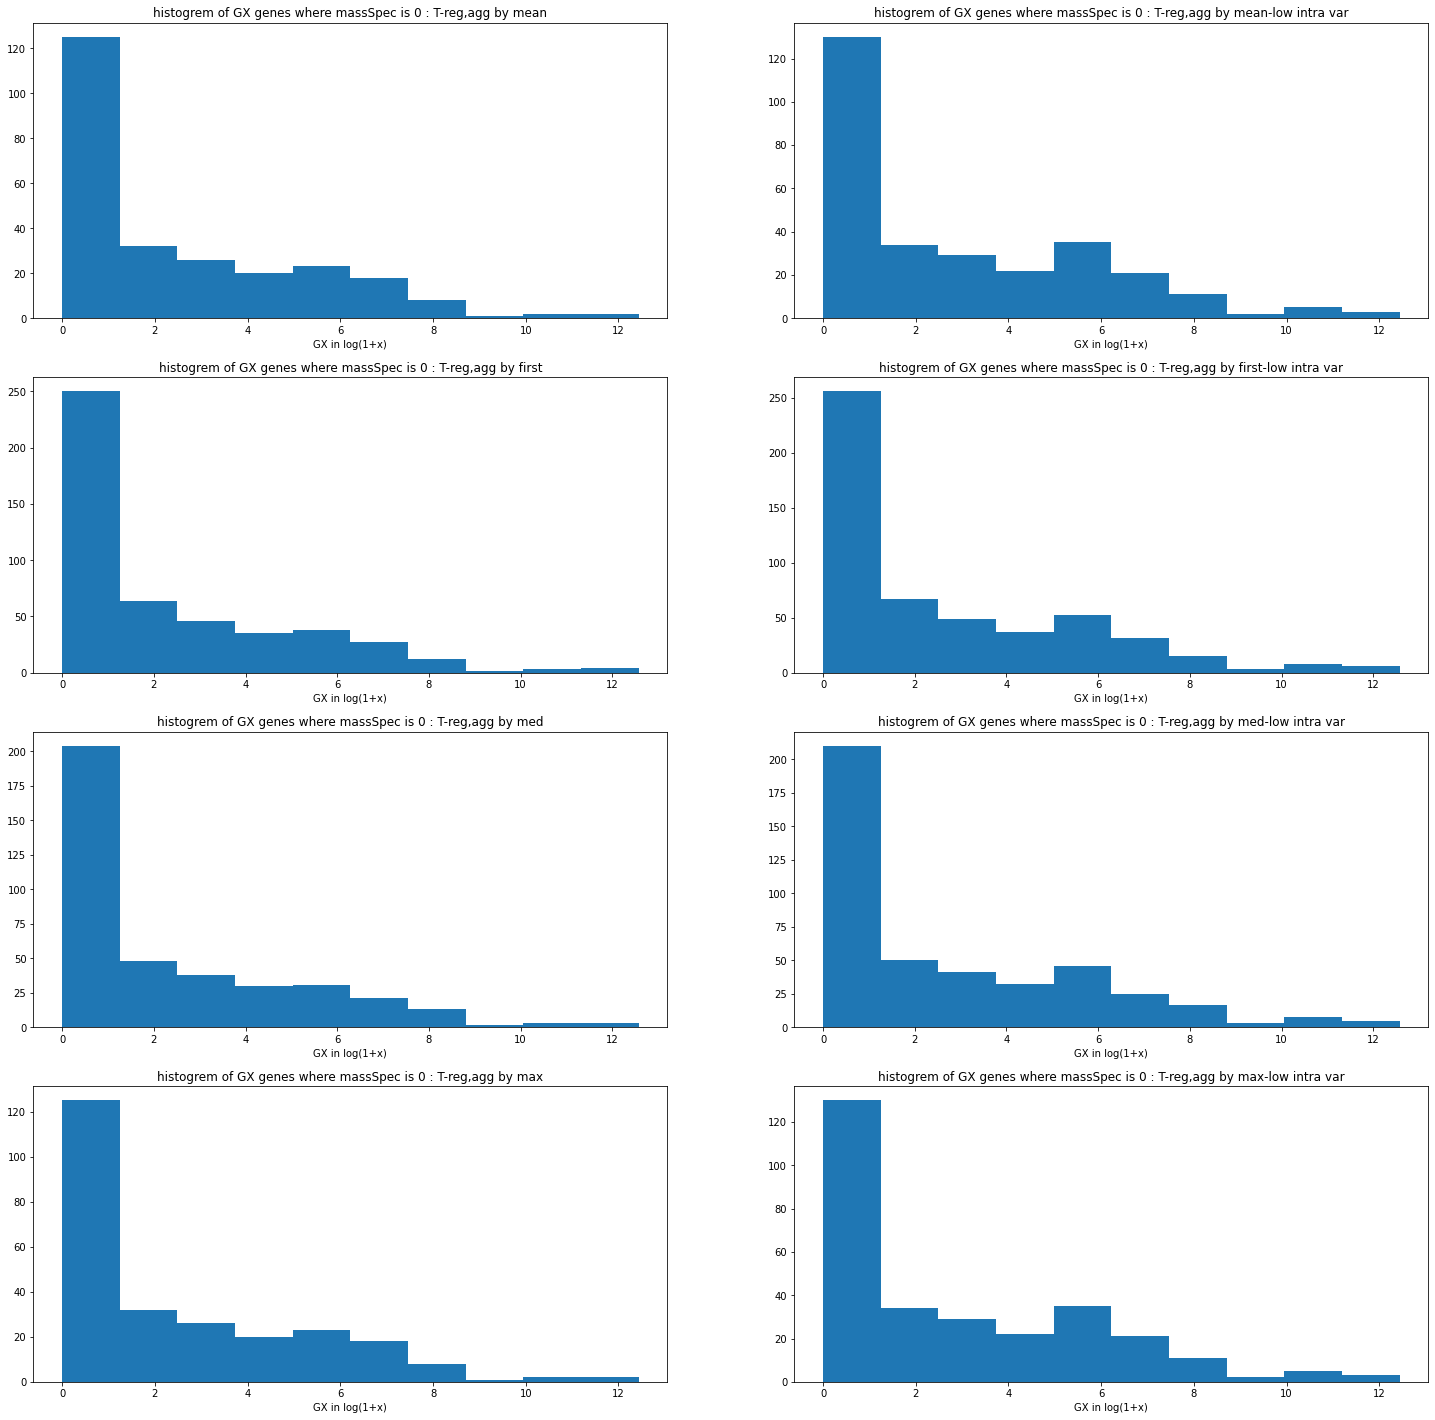

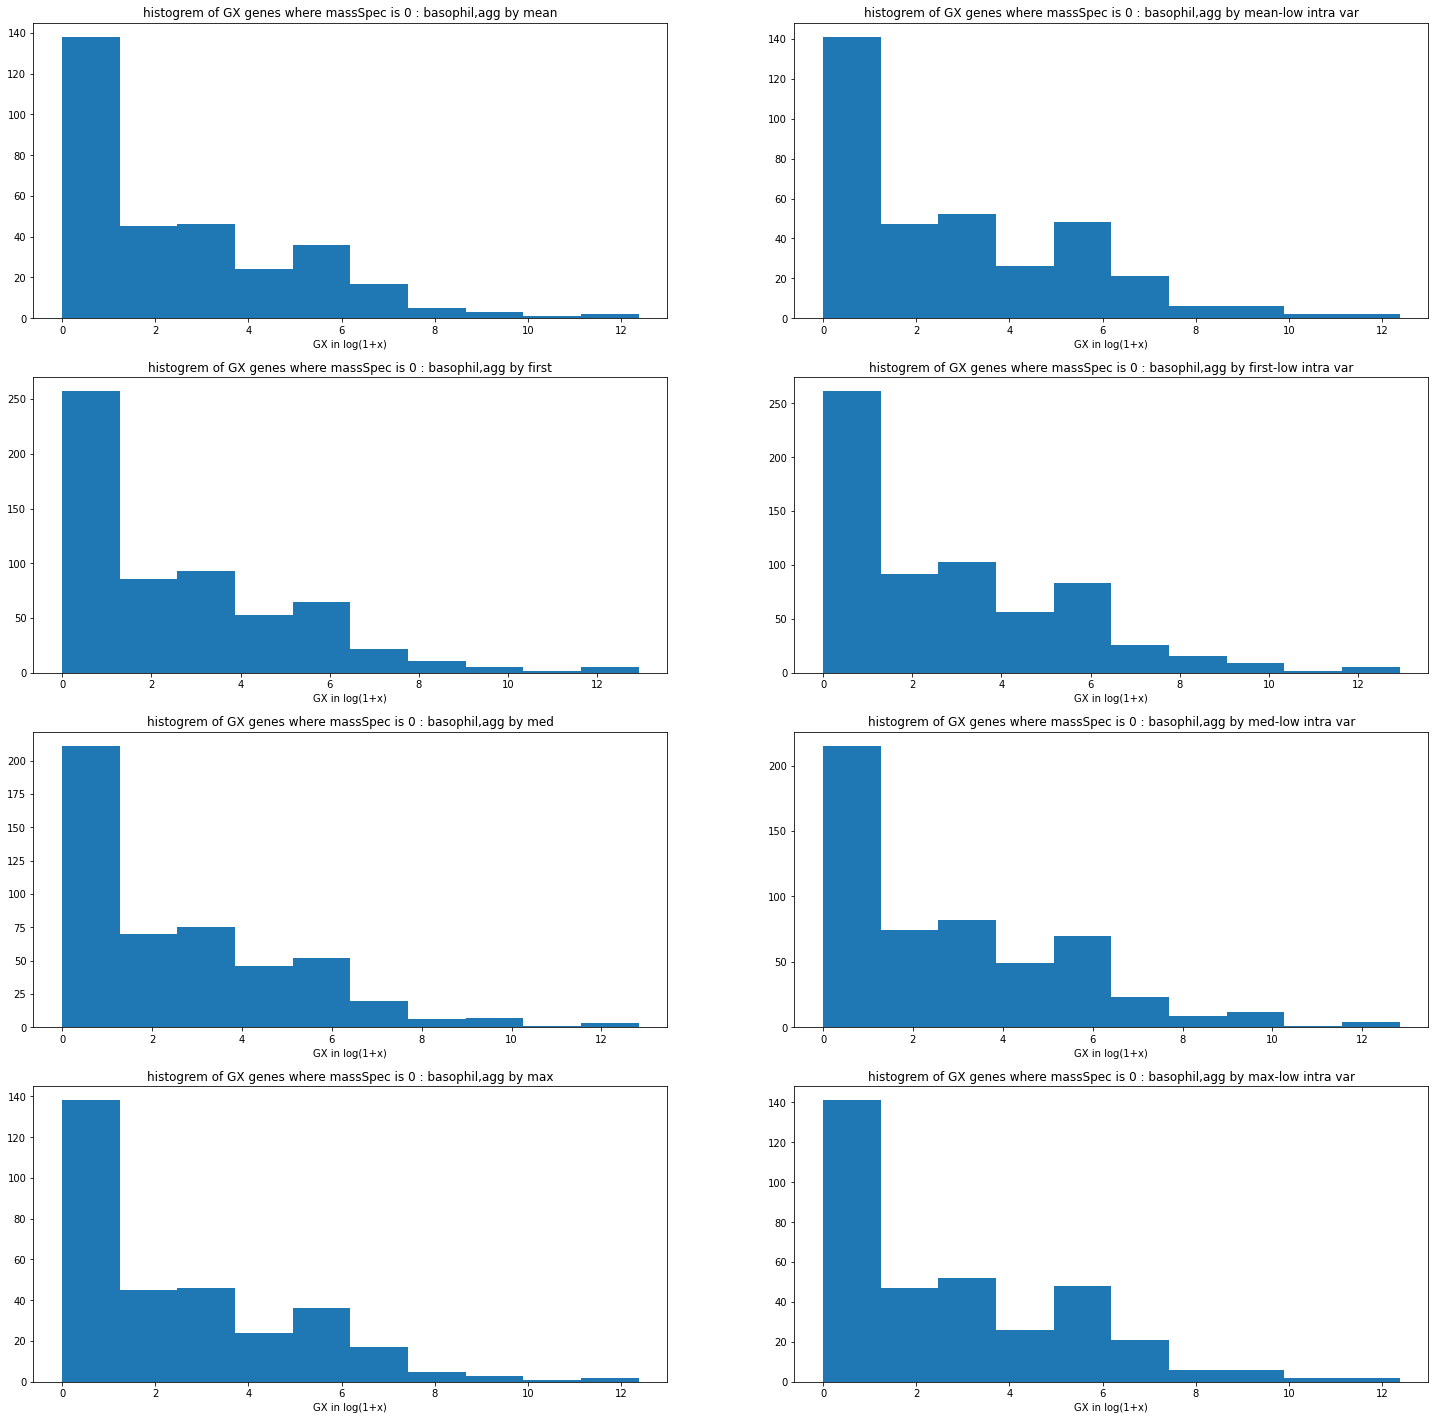

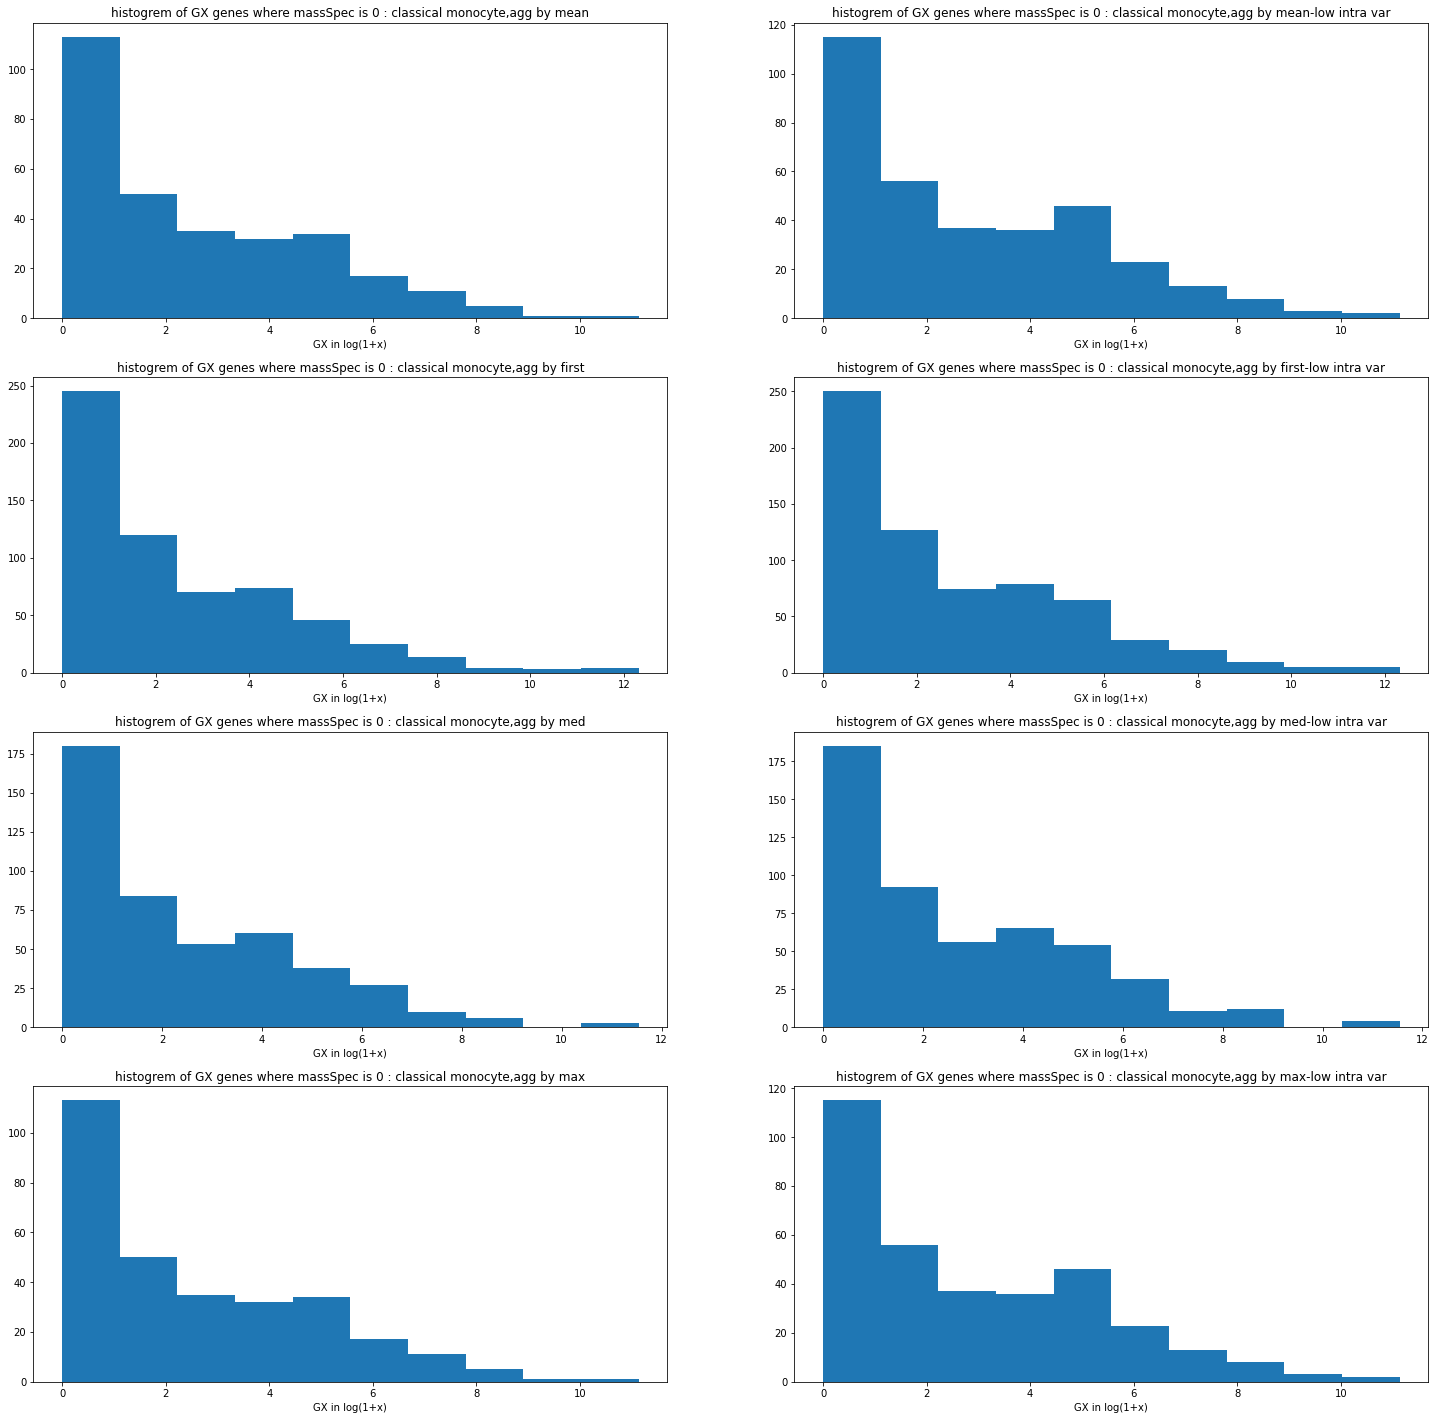

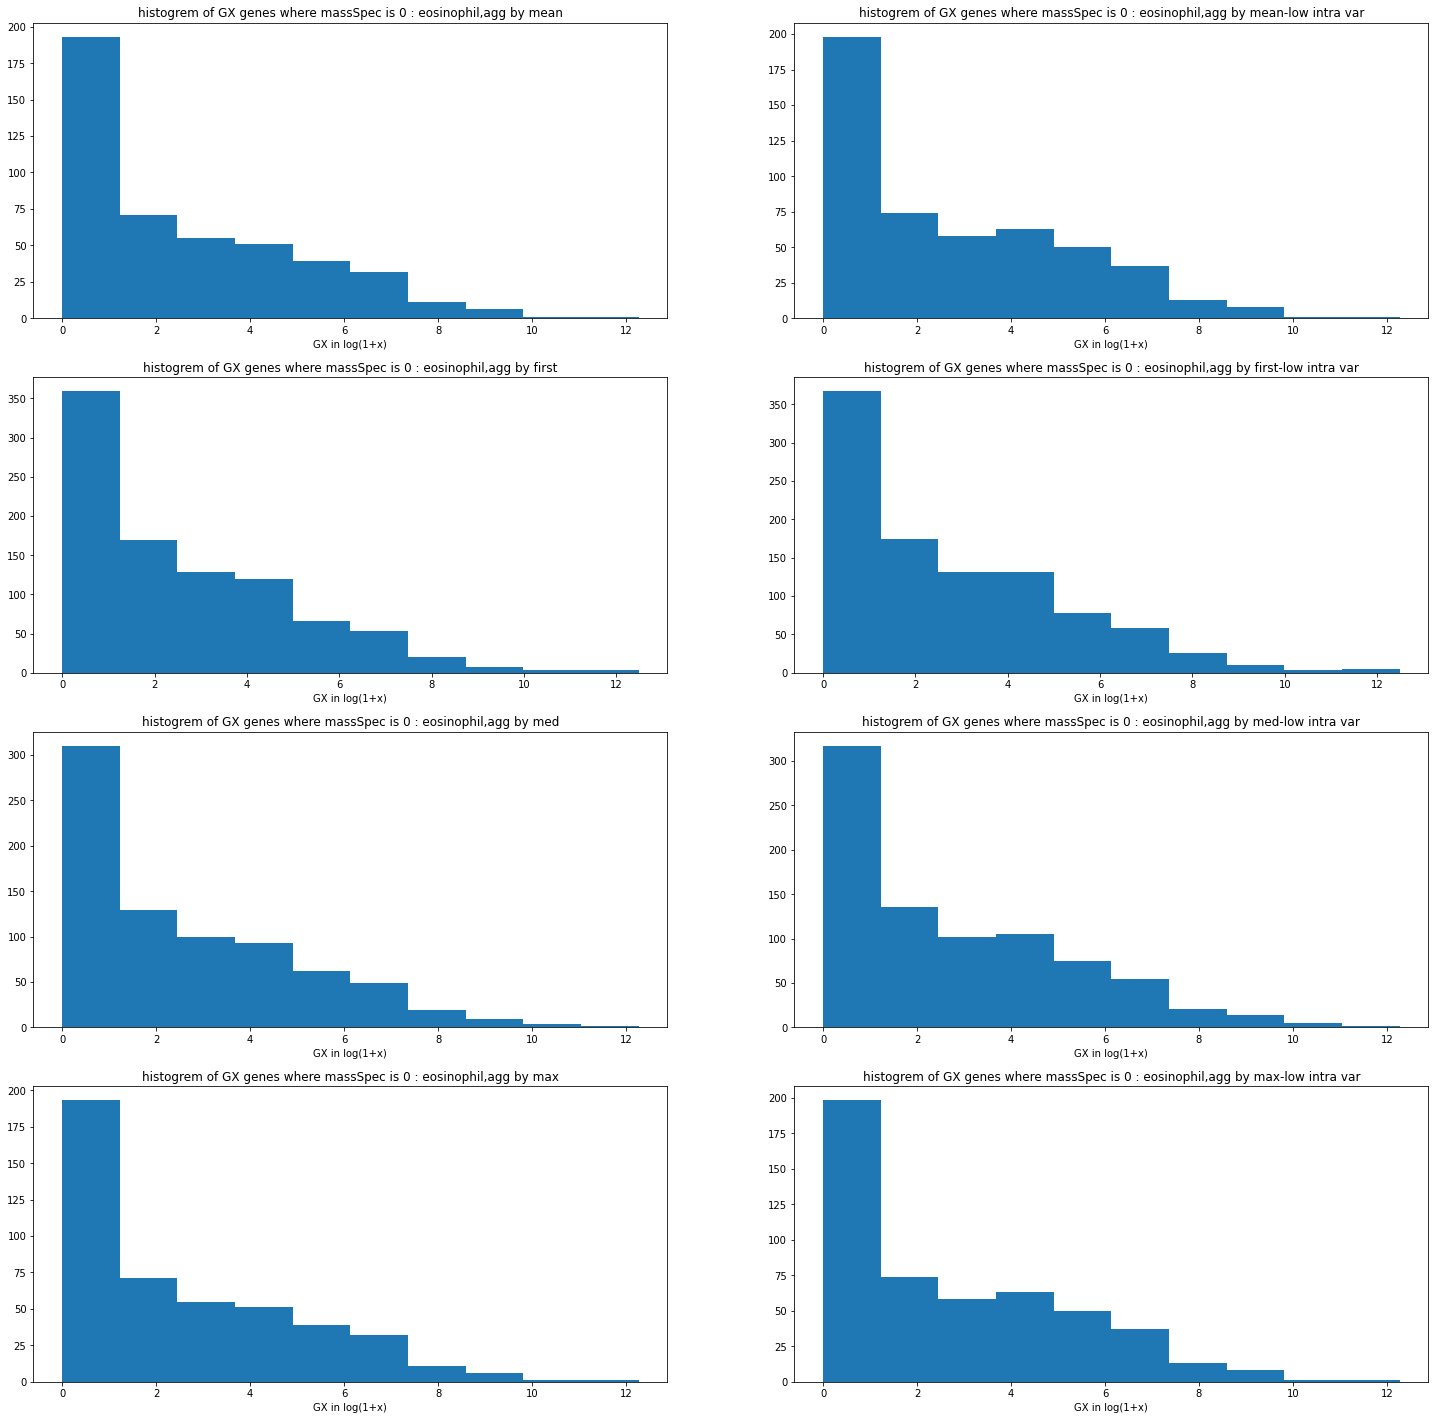

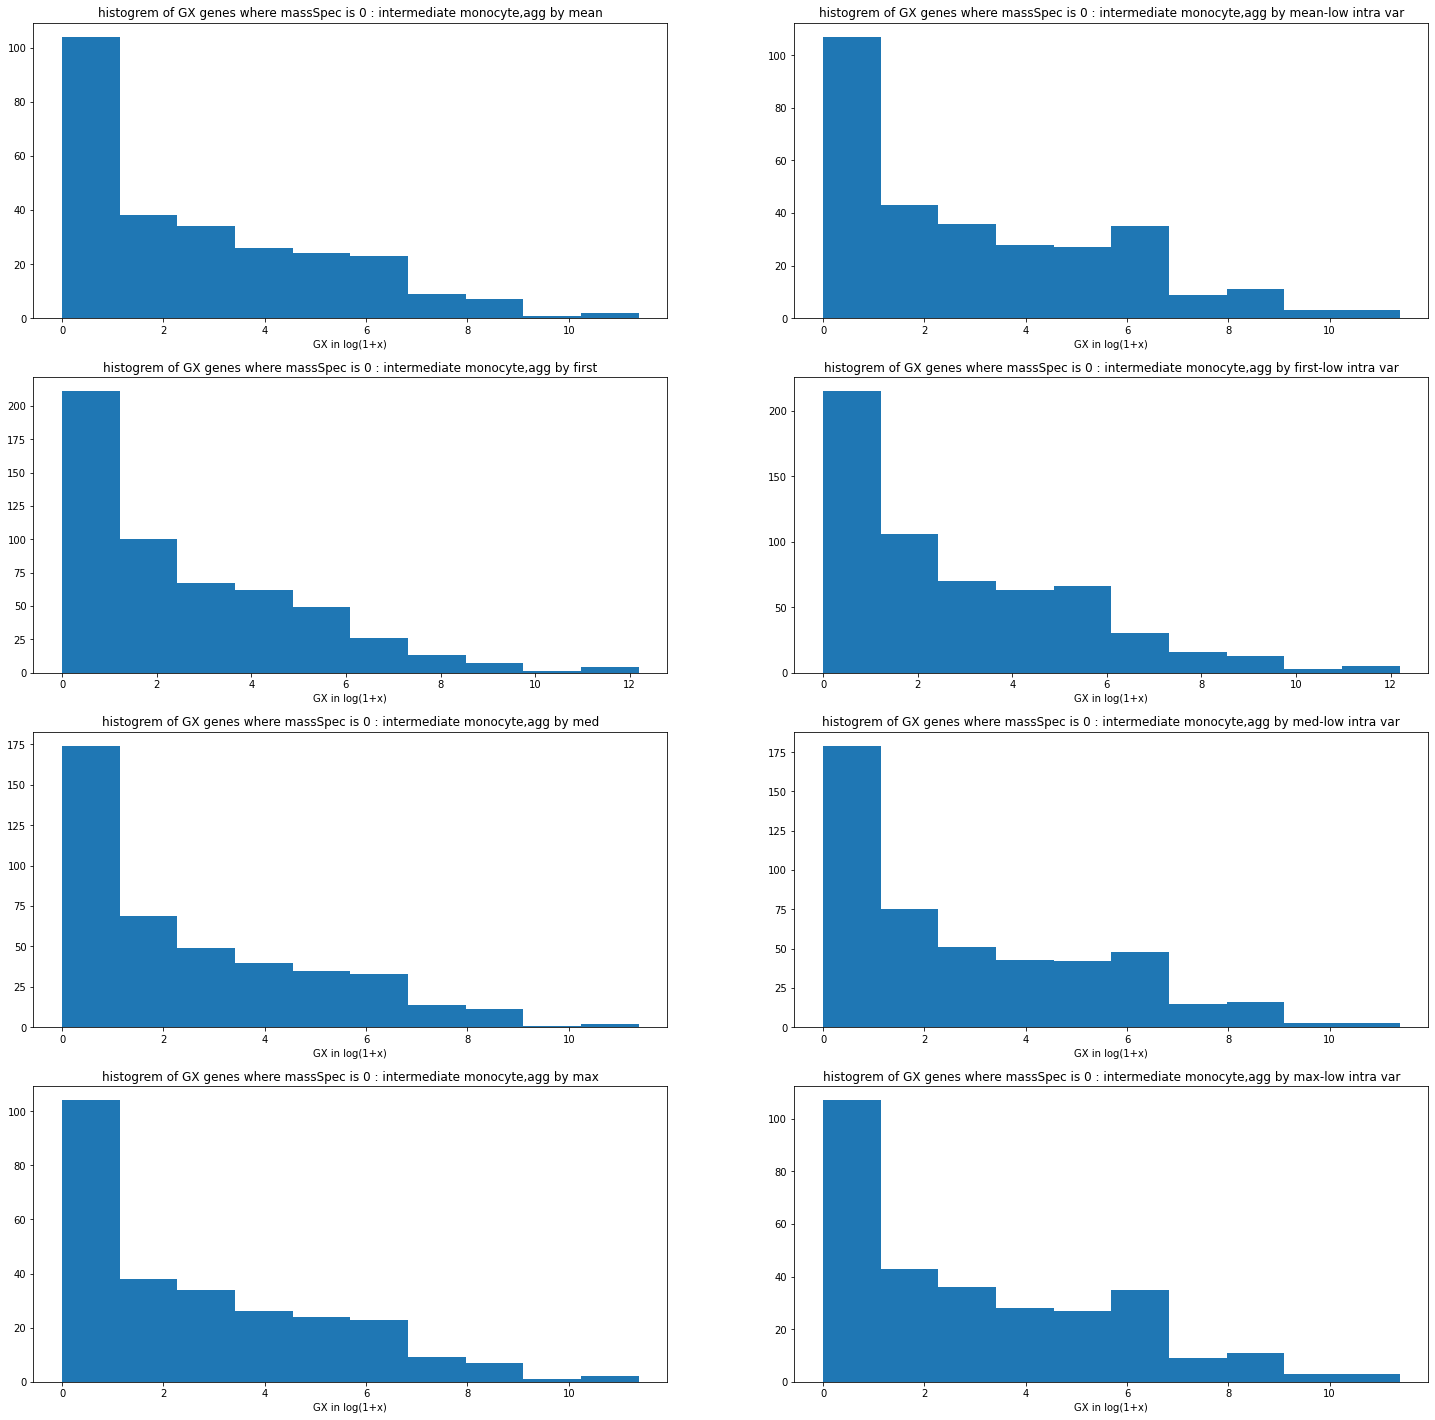

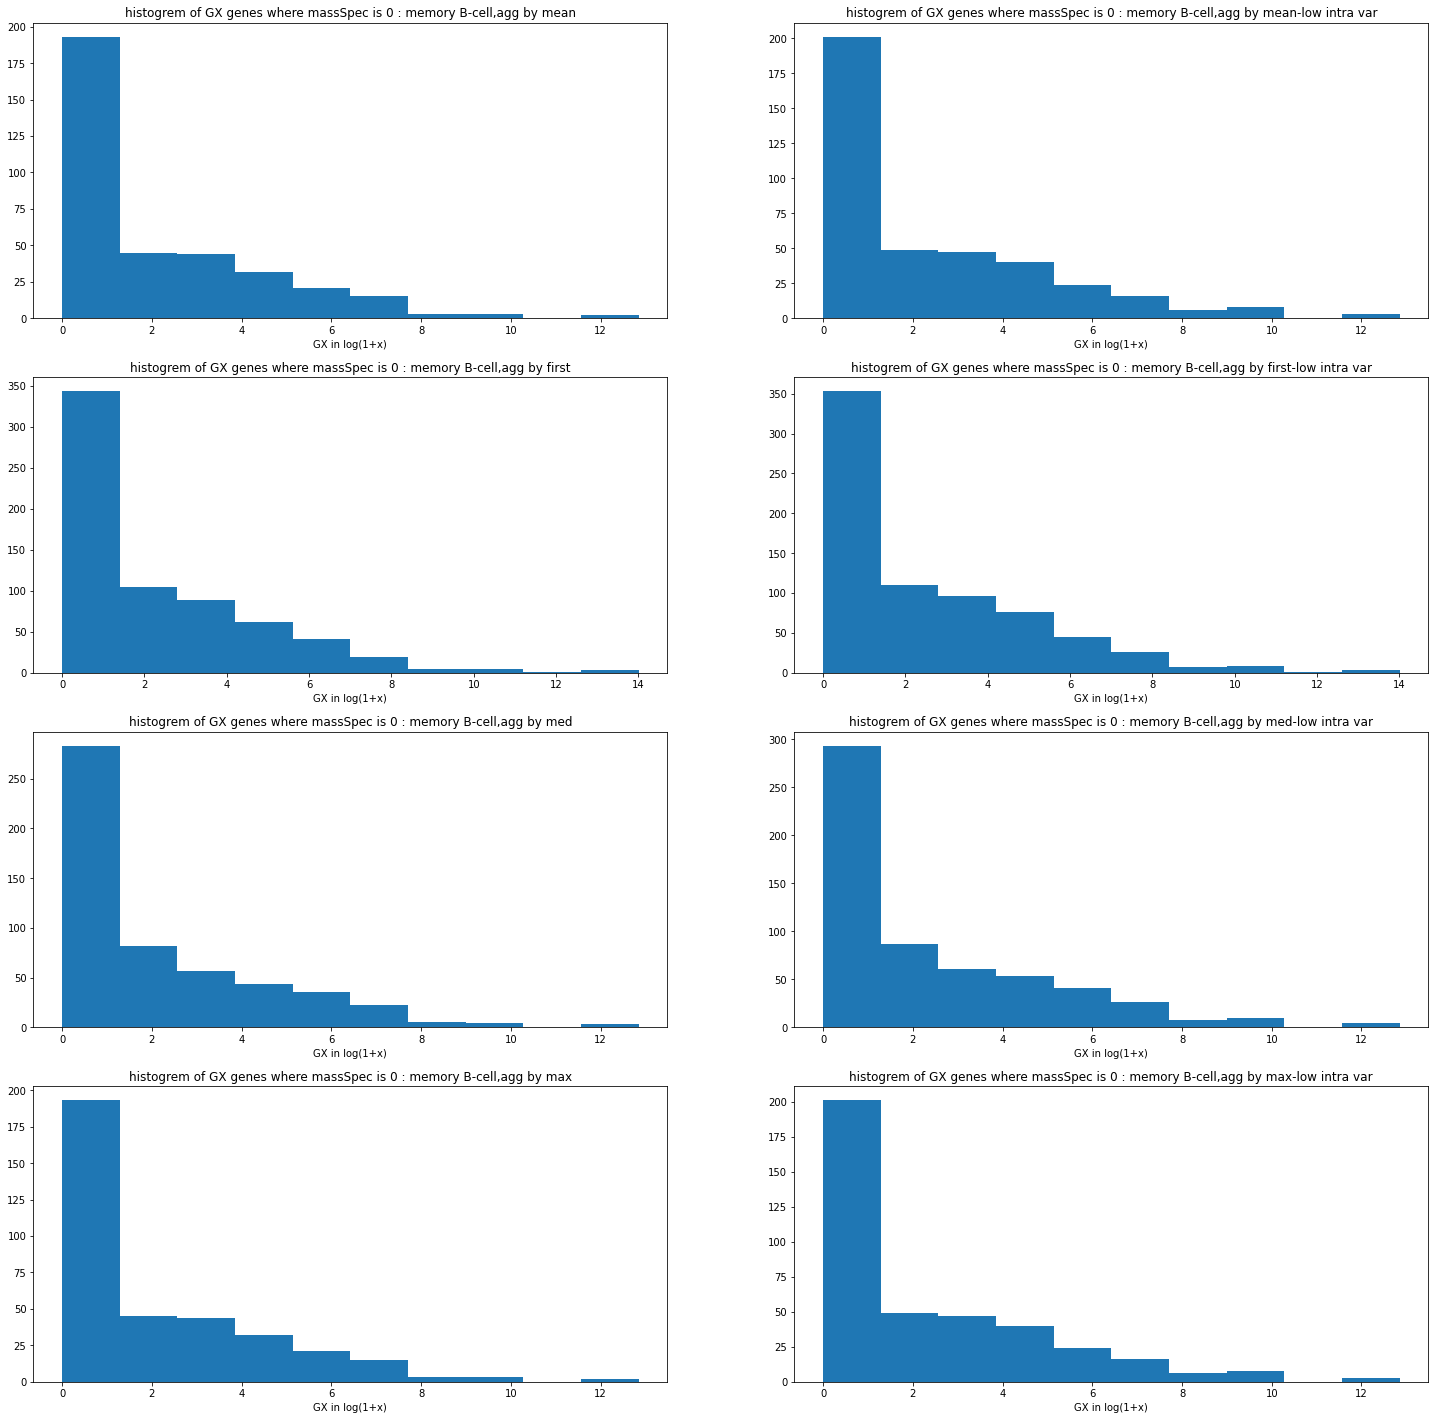

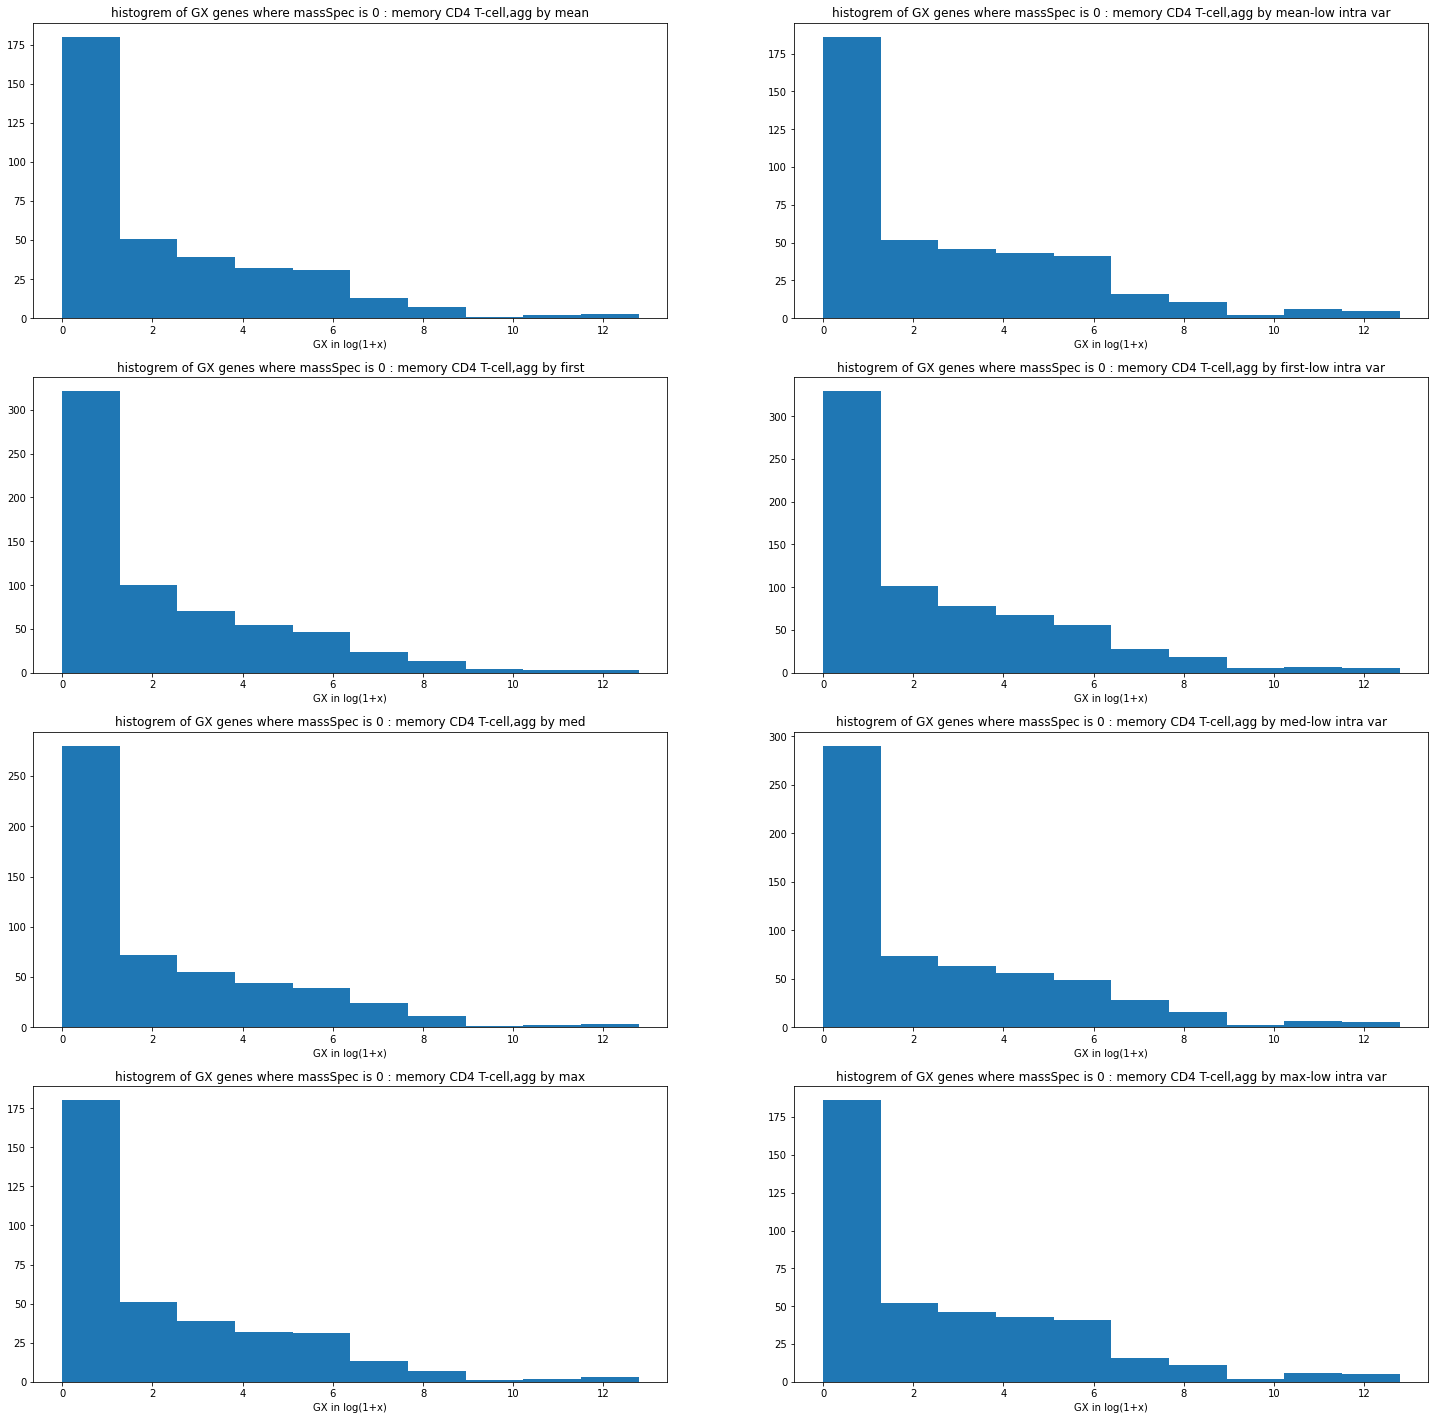

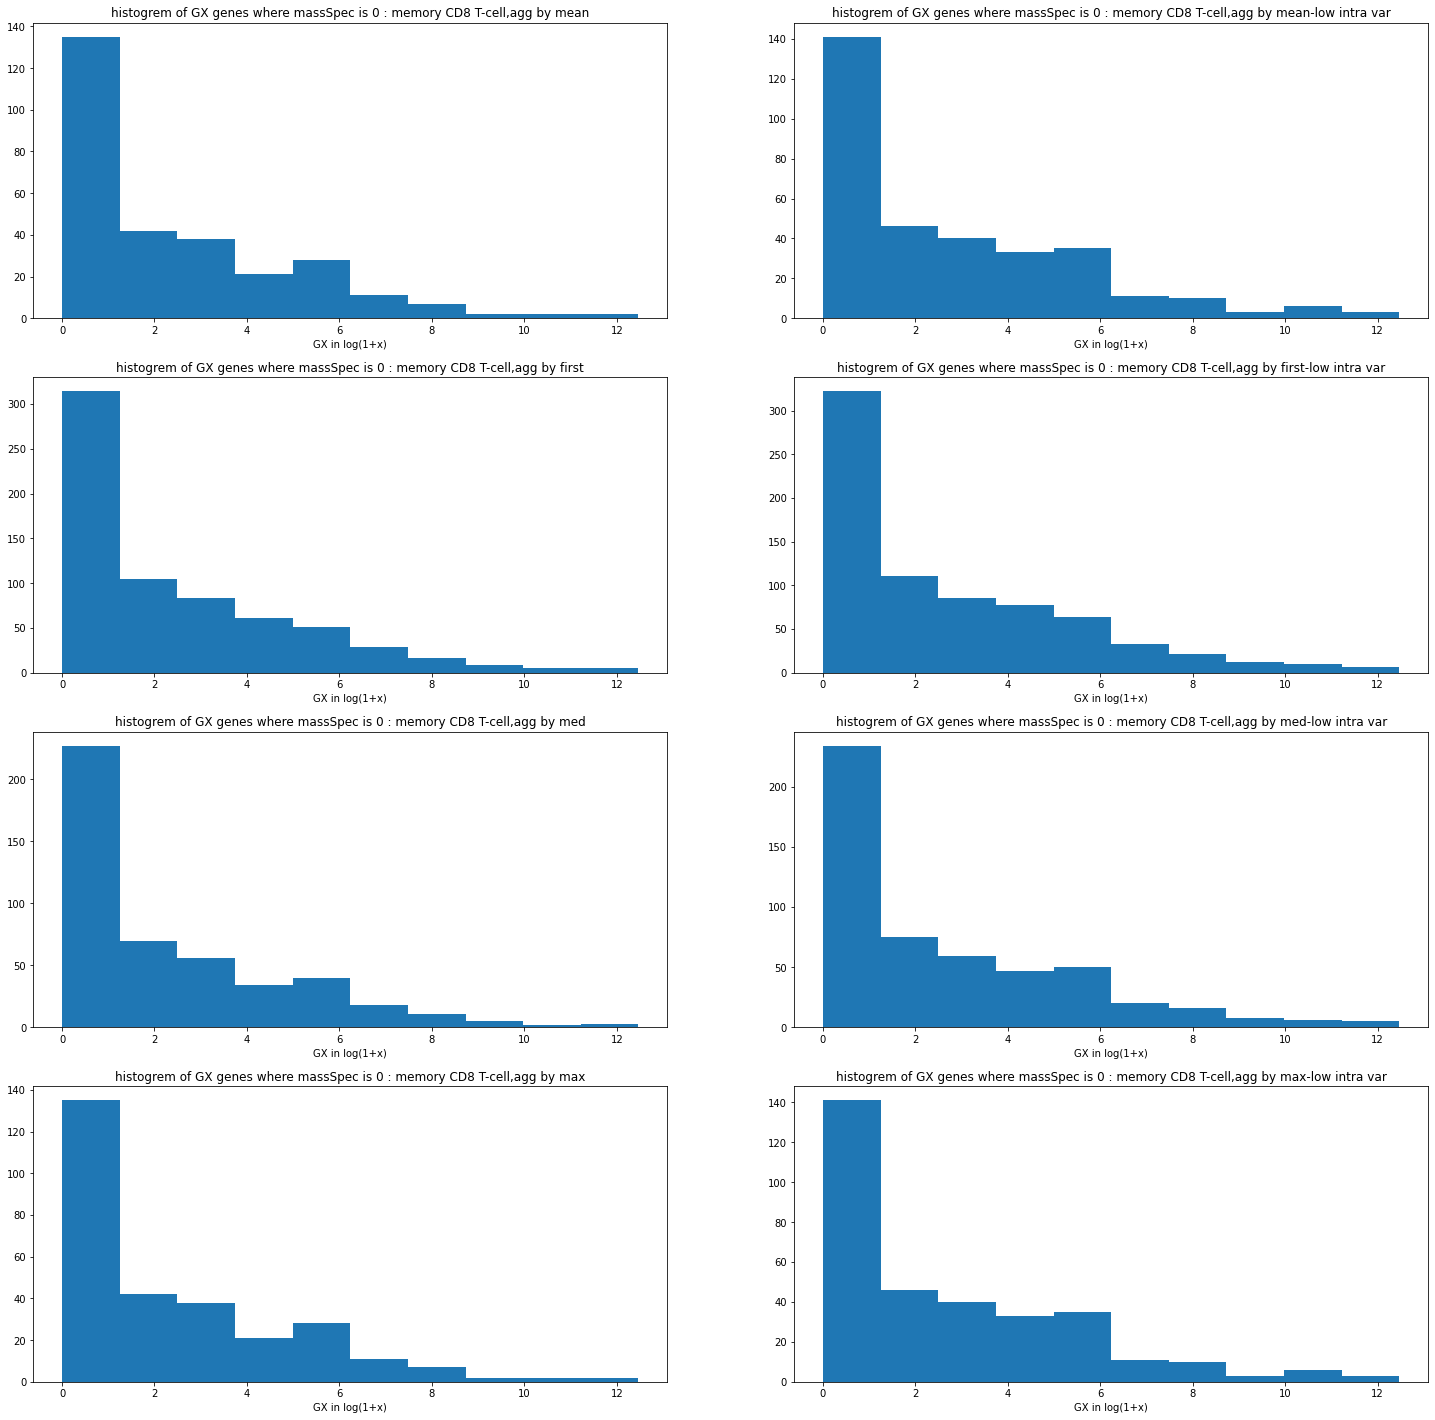

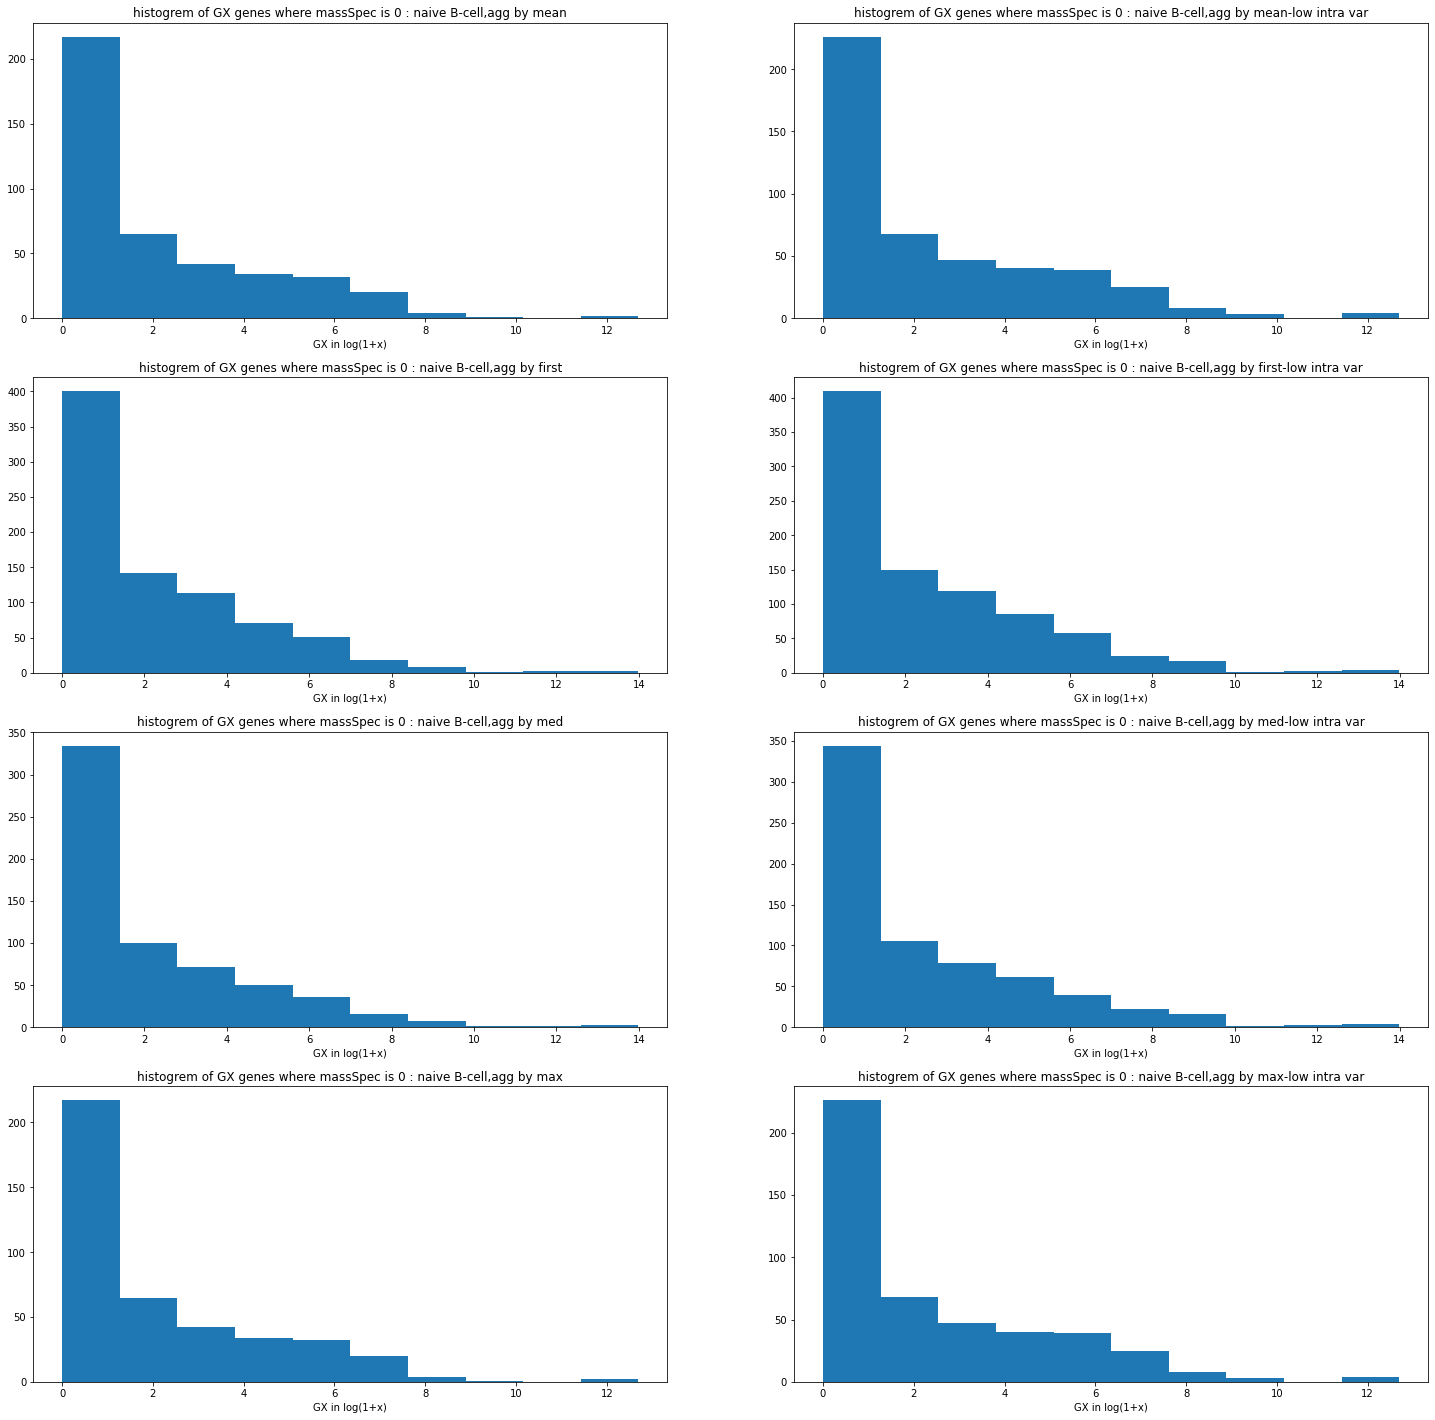

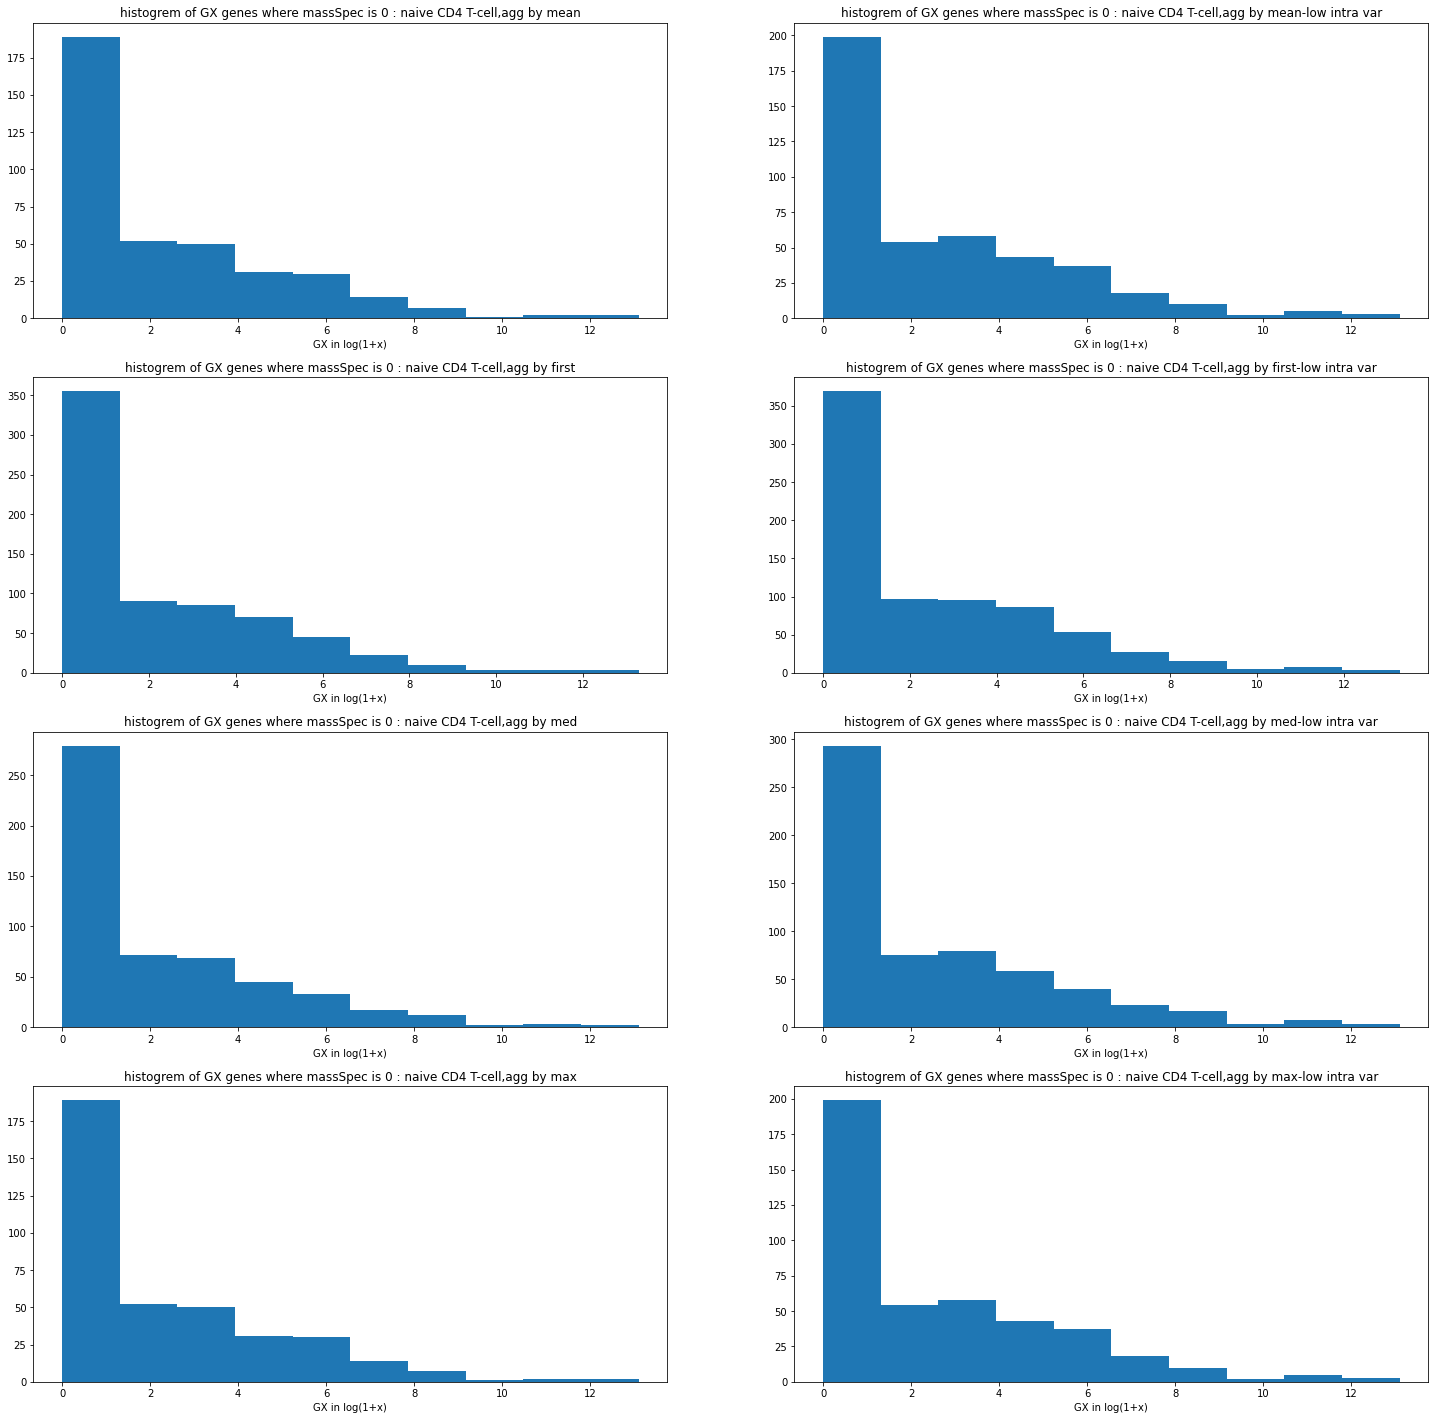

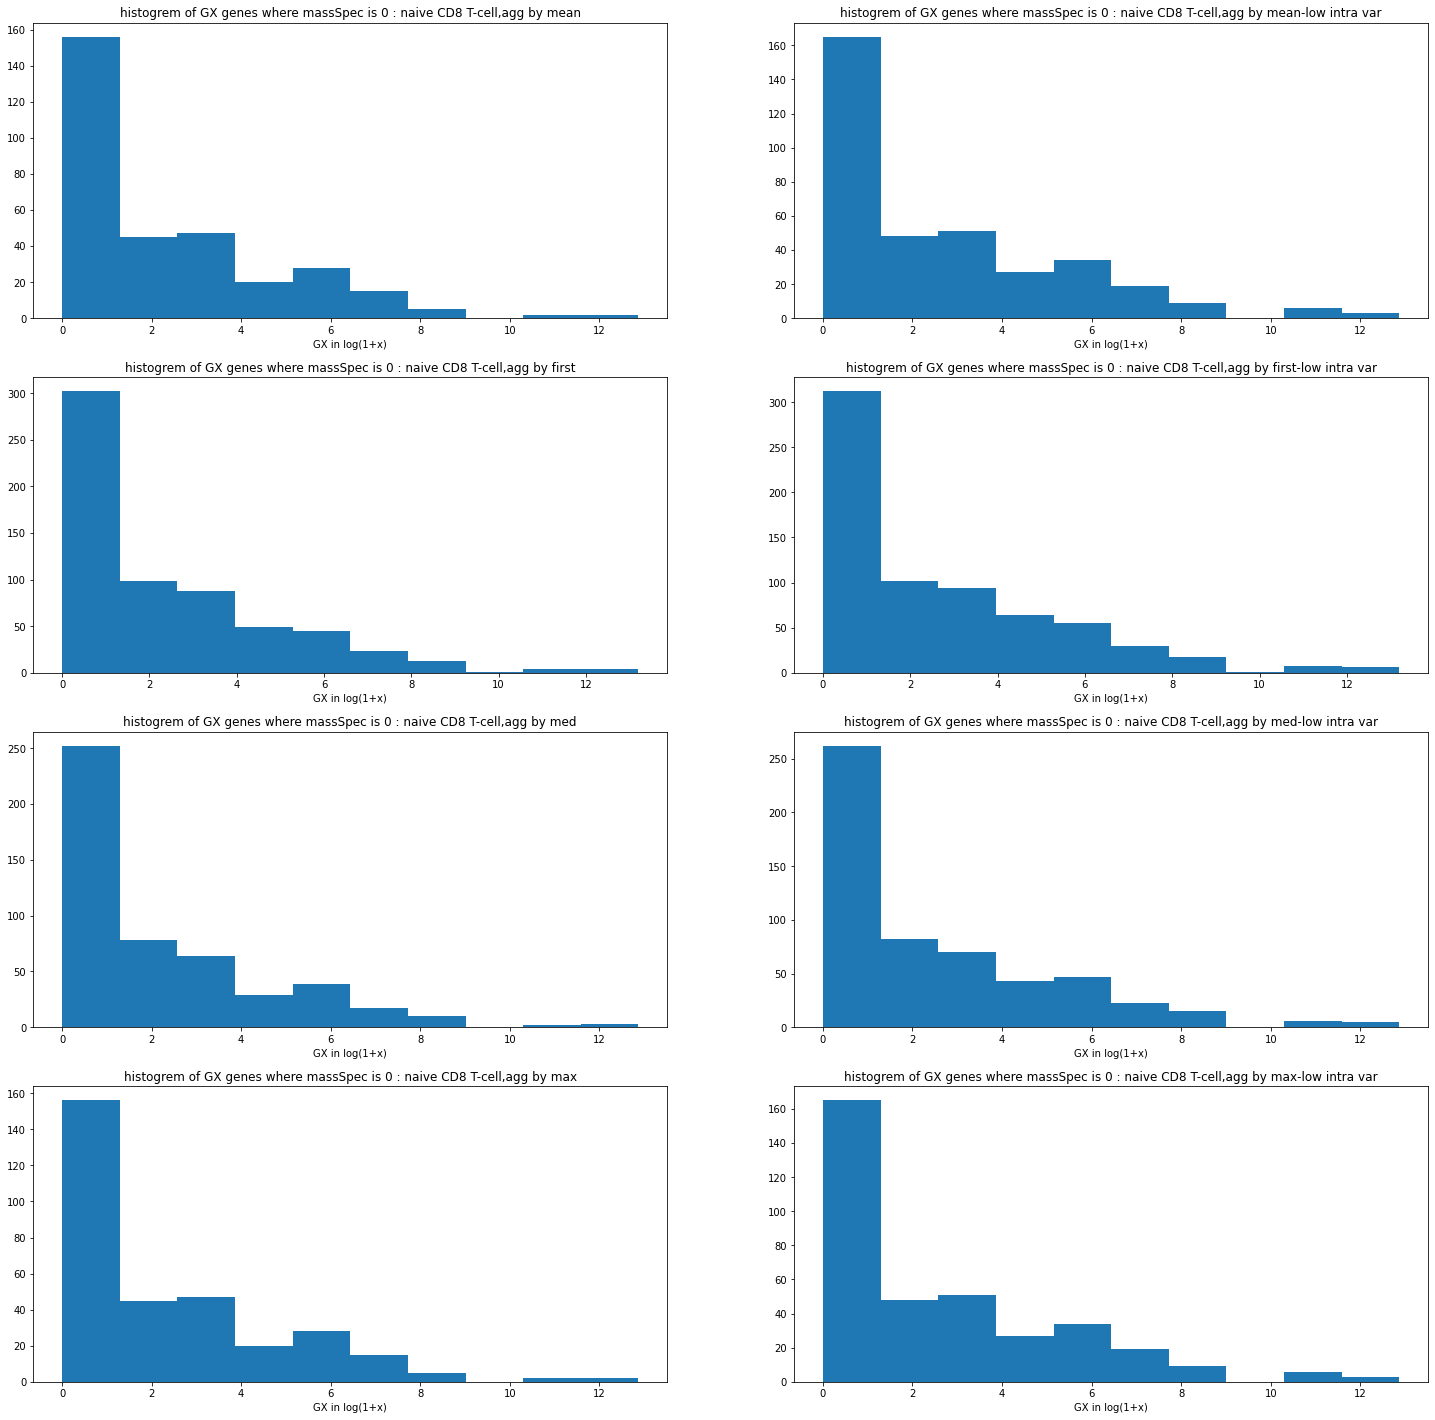

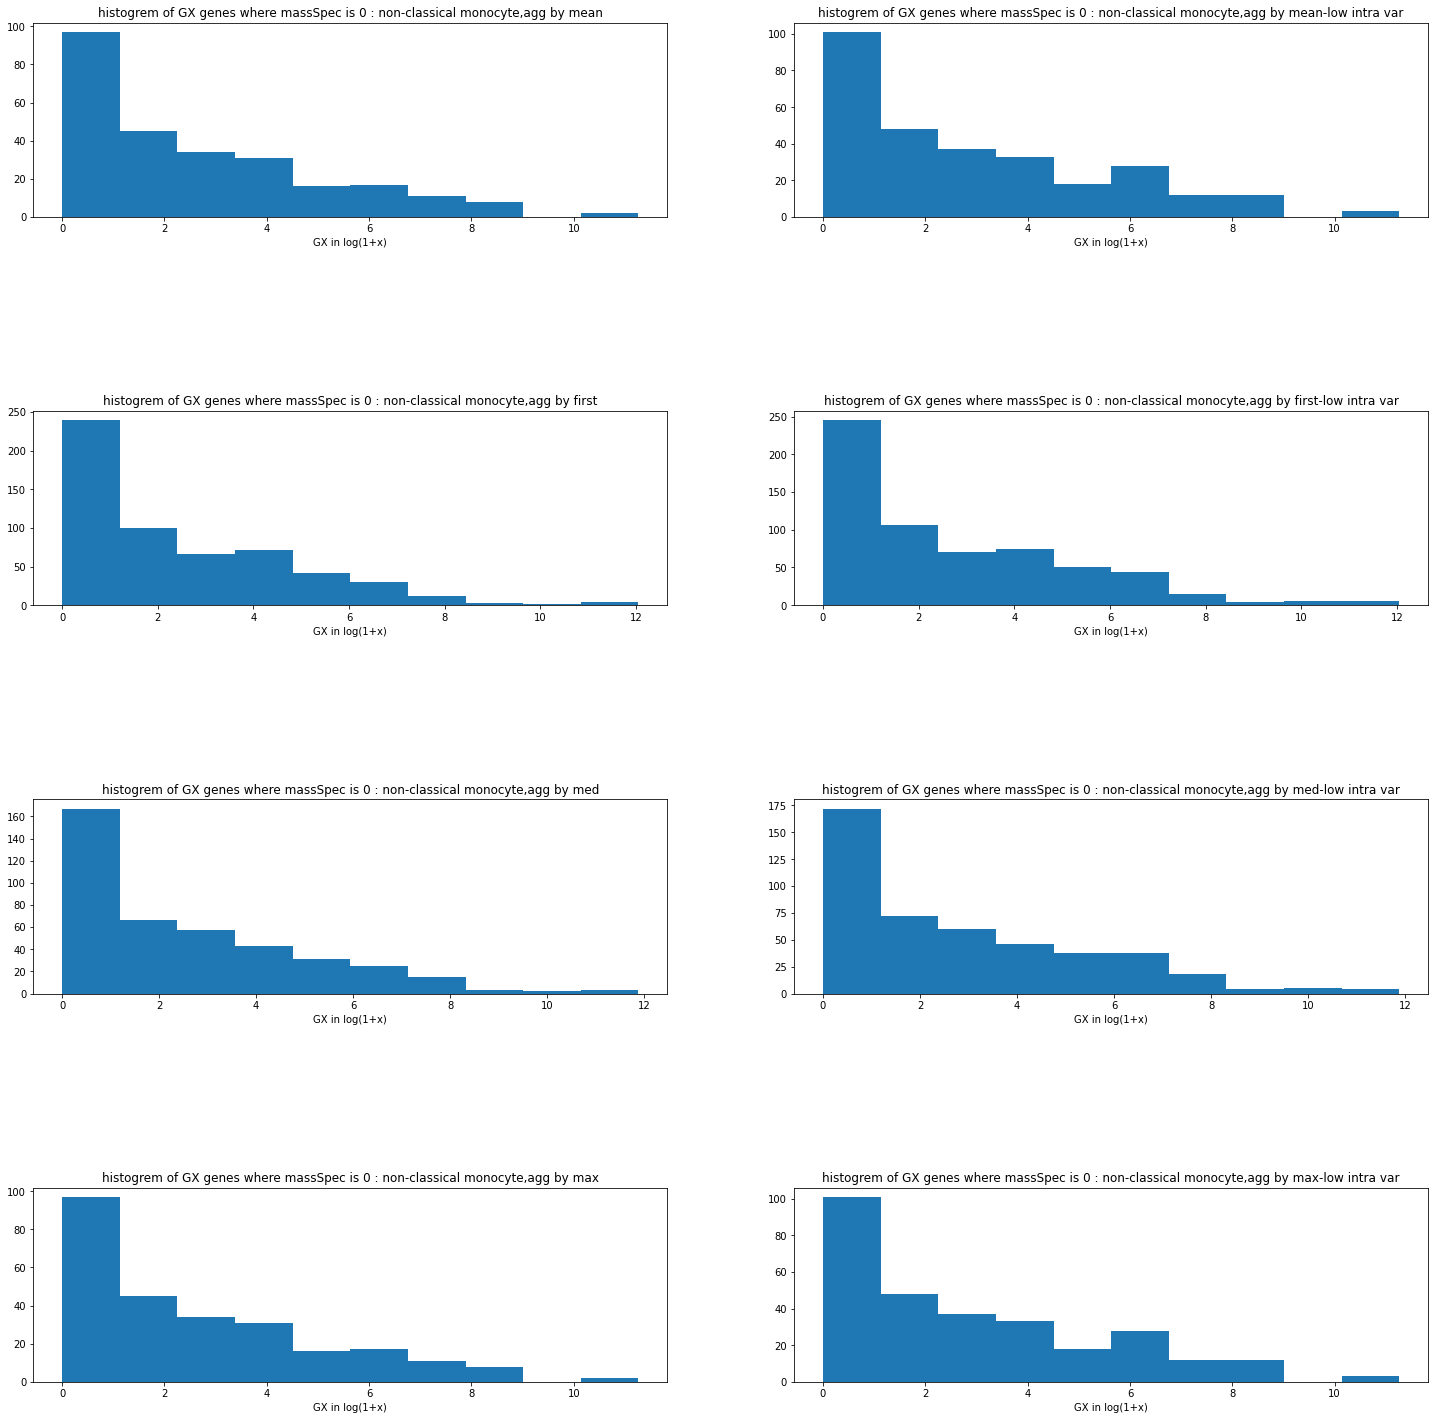

In [19]:
def plot_unexpcted_zeros_dist(mass_profiles_dict,gene_profile,genes_filtered_by_intra_var):
    '''
    mass_profile_dict = agg_type_str:profile_aggrigeted
    '''
    results = {}
    for _cell in gene_profile.columns : 
        for agg_method,mass_profile in mass_profiles_dict.items():
            merged_df = mass_profile[_cell].to_frame().merge(gene_profile[_cell].to_frame(),left_index = True,right_index = True)
            merged_df = merged_df.dropna(how="any")
            merged_df_low_intravar = merged_df.loc[genes_filtered_by_intra_var]
            merged_df_low_intravar = merged_df_low_intravar.dropna(how="any")
            
            cell_name =_cell
            
            results[f"{cell_name},agg by {agg_method}"] = merged_df[merged_df[merged_df.columns[0]]==0].dropna()
            results[f"{cell_name},agg by {agg_method}-low intra var"]=merged_df_low_intravar[merged_df_low_intravar[merged_df_low_intravar.columns[0]] == 0 ].dropna()


    for (cell_name,df),ax_index in zip(results.items(),range(len(results))) : 
        if (np.mod(ax_index,8) == 0 ) :
            fig,axs = plt.subplots(4,2,figsize=(25,25))
            axs = axs.reshape(-1)
            
        y = np.log2(1 + df[df.columns[1]])
        

        axs[np.mod(ax_index,8)].hist( y)
        axs[np.mod(ax_index,8)].set_title(f"histogrem of GX genes where massSpec is 0 : {cell_name}")
        axs[np.mod(ax_index,8)].set_xlabel("GX in log(1+x)")
#         plt.savefig(f'figures_pdfs/dist_of_zeros/histogrem of GX genes where massSpec is 0 ({cell_name.split(",")[0]})')  


    plt.subplots_adjust(hspace = 1)
    
plot_unexpcted_zeros_dist(mass_profiles_dict,filt_ptmp_rna_cell_df,genes_filtered_by_intra_var)

### signature - !!! this is comment out because the signature and the map are calculated only later !!! 

In [20]:
# signature_filt_iBAQ_profile = filt_iBAQ_profile.loc[long_possible_protein_list.map(lambda protein :protein_gene_map[protein]).dropna()]
# signature_filt_ptmp_rna_cell_df=filt_ptmp_rna_cell_df.loc[long_possible_protein_list.map(lambda protein :protein_gene_map[protein]).dropna()]
# plot_results(signature_filt_iBAQ_profile,signature_filt_ptmp_rna_cell_df)

# Jan data cross MRna variability

In [21]:
relvent_data_intensity = data_factory._build_relvent_data( DataFactory.IBD_A_RELVENT_DATA_all_vs,"Intensity")
profile_data_intensity,profile_data_relvent_data_intensity = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data_intensity,relvent_columns=["Majority protein IDs","Gene names"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data= ms.columns.tolist() ,relvent_columns=["Majority protein IDs","Gene.names"],auto_filter_by=False,log2_transformation=True)

In [22]:
index_func = lambda x:x
_profile_data_intensity,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data_intensity,mixtures,index_func=index_func)
A_all_vs = _profile_data_intensity[profile_data_relvent_data_intensity].copy(deep=True)
B_all_vs = _mixtures[mixtures_relvent_data].copy(deep=True)


In [23]:
def get_gene_to_var(profile):
    gene_to_intra_var_profile_data = profile.copy(deep=True).T
    gene_to_intra_var_profile_data["cell"]=gene_to_intra_var_profile_data.index.map(lambda x:x.split('_0')[0])
    gene_to_intra_var_profile_data = (gene_to_intra_var_profile_data.groupby("cell").std()/gene_to_intra_var_profile_data.groupby("cell").mean()).T
    gene_to_inter_var_profile_data =  profile.T.std() /profile.T.mean()

    gene_to_var = gene_to_intra_var_profile_data
    gene_to_var["inter"] = gene_to_inter_var_profile_data

    return gene_to_var[~gene_to_var["inter"].isna()]

def plot_inter_intra_cell_scatter(gene_to_var,gene_list = None,protein_list = None):
    fig, axs = plt.subplots(14,2,figsize=(15,45))
    
    if gene_list is not None : 
        gene_to_var = gene_to_var[gene_to_var.index.get_level_values("Gene names").isin(gene_list)]
    
    if protein_list is not None : 
        gene_to_var = gene_to_var[gene_to_var.index.get_level_values("major_protein_id").isin(protein_list)]
        
    for cell,ax in zip(gene_to_var.columns,axs.reshape(-1)) : 
        if cell == "inter" : 
            continue

        single_gene = gene_to_var[[cell,"inter"]].dropna()

        x = single_gene[single_gene.columns[0]]
        y = single_gene["inter"]
        
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        ax.scatter(x, y, c=z,s=100, edgecolor='')
        ax.set_title(cell)
        ax.set_xlabel("intra cell")
        ax.set_ylabel("inter cell")
        ax.set_xlim([-0.1,2.1])
        ax.set_ylim([-1,15])
    plt.subplots_adjust(hspace=0.5)  

In [24]:
gene_to_var = get_gene_to_var(A_all_vs)

## variability over protein signature

In [25]:
A_intensity = A_all_vs.copy(deep=True)[[col for col in A_all_vs.columns if "01" in col]]
B = B_all_vs[[col for col in B_all_vs.columns if "v1" in col]]

A_intensity,B = PP_proteins.pp_clean_irrelevant_proteins(A_intensity,B)

In [26]:
A_all_vs = A_all_vs.merge(_profile_data_intensity["Gene names"].to_frame(),left_index=True,right_index=True).set_index(["Gene names"],append=True)

In [37]:
long_possible_protein_list=PP_proteins.pp_entropy_largest_among_cells(A_intensity,B,n_genes_per_cell=10,only_signature=True)
# plot_inter_intra_cell_scatter(gene_to_var.copy(deep=True),protein_list =long_possible_protein_list)

## variability over Mrna signature

In [38]:
# get mutual genes with human atlas
intensity_profile = profile_data_intensity[["Gene names"] + profile_data_relvent_data_intensity].set_index("Gene names")

mass_cell_to_gene_cell_map = {'NOT_BCellmemory_01': 'memory B-cell',
                                  'NOT_BCellnaive_01' : 'naive B-cell',
                                  'NOT_BCellplasma_01' : None,
                                  'NOT_CD4TCellmTregs_01' : 'T-reg',
                                  'NOT_CD4TCellnaive_01':'naive CD4 T-cell',
                                  'NOT_CD4TCellnTregs_01':'T-reg',
                                  'NOT_CD4TCellTcm_01' : 'memory CD4 T-cell' ,
                                  'NOT_CD4TCellTem_01' : None,
                                  'NOT_CD4TCellTemra_01' :None,
                                  'NOT_CD4TCellTh1_01':None,
                                  'NOT_CD4TCellTh17_01':None,
                                  'NOT_CD4TCellTh2_01':None,
                                  'NOT_CD8TCellnaive_01':'naive CD8 T-cell',
                                  'NOT_CD8TCellTcm_01' : 'memory CD8 T-cell',
                                  'NOT_CD8TCellTem_01' : None ,
                                  'NOT_CD8TCellTemra_01' : None,
                                  'NOT_DendriticCD1c_01' : None,
                                  'NOT_DendriticCD304_01' : None,
                                  'NOT_Erythrocytes_01' : None,
                                  'NOT_Monocytesclassical_01': 'classical monocyte' ,
                                  'NOT_Monocytesintermediate_01' : 'intermediate monocyte',
                                  'NOT_Monocytesnonclassical_01': 'non-classical monocyte',
                                  'NOT_NKCellsCD56bright_01' : 'NK-cell',
                                  'NOT_NKCellsCD56dim_01': 'NK-cell',
                                  'NOT_Thrombocytes_01' : None,
                                  'NOT_Granulocyteseosinophils_01' : "eosinophil",
                                  'NOT_GranulocytesBasophil_01' : "basophil"}
mass_cell_to_gene_cell_map = {('Intensity '+k):v for k,v in mass_cell_to_gene_cell_map.items()}

filt_intensity_profile,filt_nx_rna_cell_df = return_corosponding_profiles(intensity_profile,nx_rna_cell_df,mass_cell_to_gene_cell_map)

In [39]:
#we need to take from the HA only the ones that should pass "pp_clean_irrelevant_proteins"
protein_gene_map = {tup[0]:tup[1] for tup in  A_all_vs.index.tolist()}
clean_genes_from_B_index =  B.index.map(lambda protein:protein_gene_map[protein]).dropna()
clean_filt_nx_rna_cell_df = filt_nx_rna_cell_df.loc[clean_genes_from_B_index].dropna().drop_duplicates()

long_possible_gene_list_from_HA=PP_proteins.pp_entropy_largest_among_cells(clean_filt_nx_rna_cell_df,B,n_genes_per_cell=10,only_signature=True)
# plot_inter_intra_cell_scatter(gene_to_var.copy(deep=True),gene_list=long_possible_gene_list_from_HA)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\deconv_py\preprocess\cell_specific.py:150: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  cell_relvent_gene_entropy = cell_relvent_gene_entropy.loc[cell_to_list_of_max_genes[cell]].dropna()


## mutual protein and Mrna

In [43]:
mutual_genes = long_possible_protein_list.map(lambda protein : protein_gene_map[protein]).intersection(long_possible_protein_list_from_HA)
plot_inter_intra_cell_scatter(gene_to_var.copy(deep=True),gene_list=mutual_genes)

NameError: name 'long_possible_protein_list_from_HA' is not defined

In [35]:
filt_ptmp_rna_cell_df

Blood cell,NK-cell,T-reg,basophil,classical monocyte,eosinophil,intermediate monocyte,memory B-cell,memory CD4 T-cell,memory CD8 T-cell,naive B-cell,naive CD4 T-cell,naive CD8 T-cell,non-classical monocyte
home_cor_gene,,,,,,,,,,,,,
A1BG,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.2,0.5,0.0,0.0,0.3,0.0
AAAS,20.9,21.6,2.0,17.1,12.6,20.5,22.6,20.2,22.7,24.4,25.3,26.9,22.8
AACS,7.0,2.4,6.8,1.9,6.1,0.6,2.7,3.8,3.4,1.5,5.1,3.7,0.8
AAK1,2.1,2.0,1.5,0.7,0.3,0.3,0.2,2.4,1.9,0.5,3.1,2.7,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW10,8.6,7.1,6.9,7.6,7.5,10.9,7.0,7.7,7.7,6.3,6.7,8.8,9.7
ZYG11B,1.0,1.2,0.4,0.8,0.9,0.4,0.7,1.0,0.6,0.7,1.3,1.0,0.7
ZYX,20.9,20.9,19.9,61.7,46.2,67.2,3.4,21.7,28.7,2.1,12.7,16.2,82.2


In [ ]:
filt_ptmp_rna_cell_df.to_pickle("filt_ptmp_rna_cell_df.pkl")
filt_intensity_profile.to_pickle("filt_intensity_profile.pkl")

# inter-cell variability proteins vs genes

In [ ]:
from scipy.stats import zscore
from mpl_toolkits.mplot3d import Axes3D 

_z_score_clean_filt_nx_rna_cell_df = filt_nx_rna_cell_df.groupby(filt_nx_rna_cell_df.index).first()
_z_score_clean_filt_nx_rna_cell_df = _z_score_clean_filt_nx_rna_cell_df.T.apply(zscore).T
z_score_clean_filt_nx_rna_cell_df = _z_score_clean_filt_nx_rna_cell_df.loc[clean_genes_from_B_index].dropna(how="all")

_z_score_clean_filt_intensity_profile = filt_intensity_profile.groupby(filt_intensity_profile.index).first()
_z_score_clean_filt_intensity_profile = _z_score_clean_filt_intensity_profile.T.apply(zscore).T

z_score_clean_filt_intensity_profile =_z_score_clean_filt_intensity_profile.loc[clean_genes_from_B_index].dropna(how="all")


In [ ]:
from scipy.stats import zscore
from mpl_toolkits.mplot3d import Axes3D 






_z_score_clean_filt_nx_rna_cell_df = filt_nx_rna_cell_df.groupby(filt_nx_rna_cell_df.index).first()
_z_score_clean_filt_nx_rna_cell_df = _z_score_clean_filt_nx_rna_cell_df.T.apply(zscore).T
z_score_clean_filt_nx_rna_cell_df = _z_score_clean_filt_nx_rna_cell_df.loc[clean_genes_from_B_index].dropna(how="all")

_z_score_clean_filt_intensity_profile = filt_intensity_profile.groupby(filt_intensity_profile.index).first()
_z_score_clean_filt_intensity_profile = _z_score_clean_filt_intensity_profile.T.apply(zscore).T

z_score_clean_filt_intensity_profile =_z_score_clean_filt_intensity_profile.loc[clean_genes_from_B_index].dropna(how="all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',figsize=(15,45))
for cell,ax in zip(z_score_clean_filt_intensity_profile.columns,axs.reshape(-1)) :
    x = z_score_clean_filt_nx_rna_cell_df[cell].dropna()
    y = z_score_clean_filt_intensity_profile[cell].dropna()
    
    x = x.groupby(x.index).first()
    y = y.groupby(y.index).first()
    
    mut_index = x.index.intersection(y.index)
#     print(mut_index)
    
    x = x[mut_index]
    y = y[mut_index]
    

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    ax.scatter(x, y, c=z,s=100, edgecolor='')
    ax.set_title(cell)
    ax.set_xlabel("Mrna zscore")
    ax.set_ylabel("massSpec zscore")
    ax.set_xlim([-2,4])
    ax.set_ylim([-2,4])

#     rect_red = patches.Rectangle((2,2),2,2,linewidth=1,edgecolor='r',facecolor='none')
#     rect_blue = patches.Rectangle((2,2),-4,2,linewidth=1,edgecolor='b',facecolor='none')
#     ax.add_patch(rect_red)
#     ax.add_patch(rect_blue)
plt.subplots_adjust(hspace=0.5)  
    

In [ ]:
fig = plt.figure(figsize=(15,45))
ax = fig.add_subplot(111, projection='3d')

x = z_score_clean_filt_nx_rna_cell_df[cell].dropna()
y = z_score_clean_filt_intensity_profile[cell].dropna()

x = x.groupby(x.index).first()
y = y.groupby(y.index).first()

mut_index = x.index.intersection(y.index)
#     print(mut_index)

x = x[mut_index]
y = y[mut_index]


xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax.scatter(x.values, y.values,z)
ax.set_title(cell)
ax.set_xlabel("Mrna zscore")
ax.set_ylabel("massSpec zscore")
ax.set_zlabel("hela std")
ax.set_xlim([-2,4])
ax.set_ylim([-2,4])
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()

In [ ]:
_z_score_clean_filt_nx_rna_cell_df

In [ ]:
ax = plt.subplot()
ax.set_title("hist of correlation between Mrna and massSpec across genes")
filt_nx_rna_cell_df.corrwith(filt_intensity_profile,axis=1).hist(ax=ax)
plt.show()
